# XAI Assignment 2

2022-35854 Jisoo Jang

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt

shap.initjs()

main_path = Path().absolute().parent
data_path = main_path / 'data' / 'crime_rate'
model_path = Path() / 'checkpoints'

In [2]:
cr_data = pd.read_csv(data_path / 'estimated_crimes.csv')
cr_data = cr_data[cr_data['year'] <= 2019]
cr_data.rename(columns={'state_name':'state name'}, inplace=True)

demography = pd.read_csv(data_path / 'demography.csv')
demography.columns = [c.lower() for c in demography.columns]
demography = demography.rename(columns={'other races': 'number of other races', 'percent other race': 'percent of other races'})

economics = pd.read_csv(data_path / 'economics.csv')
economics.columns = [c.lower() for c in economics.columns]

social = pd.read_csv(data_path / 'social_characteristics.csv')
social.columns = [c.lower() for c in social.columns]

merge_data = cr_data.set_index(['year', 'state name']) \
                    .join(demography.set_index(['year', 'state name']), how='left') \
                    .join(economics.set_index(['year', 'state name']), how='left') \
                    .join(social.set_index(['year', 'state name']), how='left')

print('stats of data')
for d_name, d in zip(['cr_data', 'demography', 'economics', 'social'], [cr_data, demography, economics, social]):
    print(f'{d_name}: {d.shape} | unique years: {len(d["year"].unique())} | unique states: {len(d["state name"].unique())}')

# missing state will automatically dropped from merging stage
merged_columns = merge_data.columns
for c in merged_columns:
    indices = merge_data[merge_data[c].isnull()].index
    merge_data.drop(indices, axis=0, inplace=True)

merge_data['overall crime rate'] *= 1000
merge_data = merge_data.reset_index().sort_values(['state name', 'year'])
merge_data.drop(columns=['state_abbr'], inplace=True)

# population records have conflicts in demography, recalculate the actual amount using percentage
population = merge_data.loc[:, ['state name', 'year', 'population']]
merge_data.drop(columns=['total population'], inplace=True)
p_cols = demography.columns[demography.columns.str.contains('percent')]
n_cols = demography.columns[demography.columns.str.contains('number')]

for i, p_col in enumerate(p_cols):
    n_col = n_cols[i]
    merge_data.loc[:, n_col] = (population['population'] * merge_data.loc[:, p_col] / 100).astype(np.int64)

# delete the other informations that duplicated with crime numbers, seperate the charteristic of demography, economics and social information
except_cols = cr_data.columns[~cr_data.columns.isin(['year', 'state name', 'state_abbr', 'population', 'overall crime rate'])]
cols = merge_data.columns[~merge_data.columns.isin(except_cols)]
merge_data = merge_data.loc[:, cols]
# only use train data
char_data = merge_data.loc[(merge_data['year'] < 2019), cols[~cols.isin(['overall crime rate'])]].set_index(['state name', 'year'])

stats of data
cr_data: (510, 14) | unique years: 10 | unique states: 51
demography: (510, 29) | unique years: 10 | unique states: 51
economics: (500, 199) | unique years: 10 | unique states: 50
social: (500, 9) | unique years: 10 | unique states: 50


In [3]:
merge_data.shape, char_data.shape

((500, 234), (450, 231))

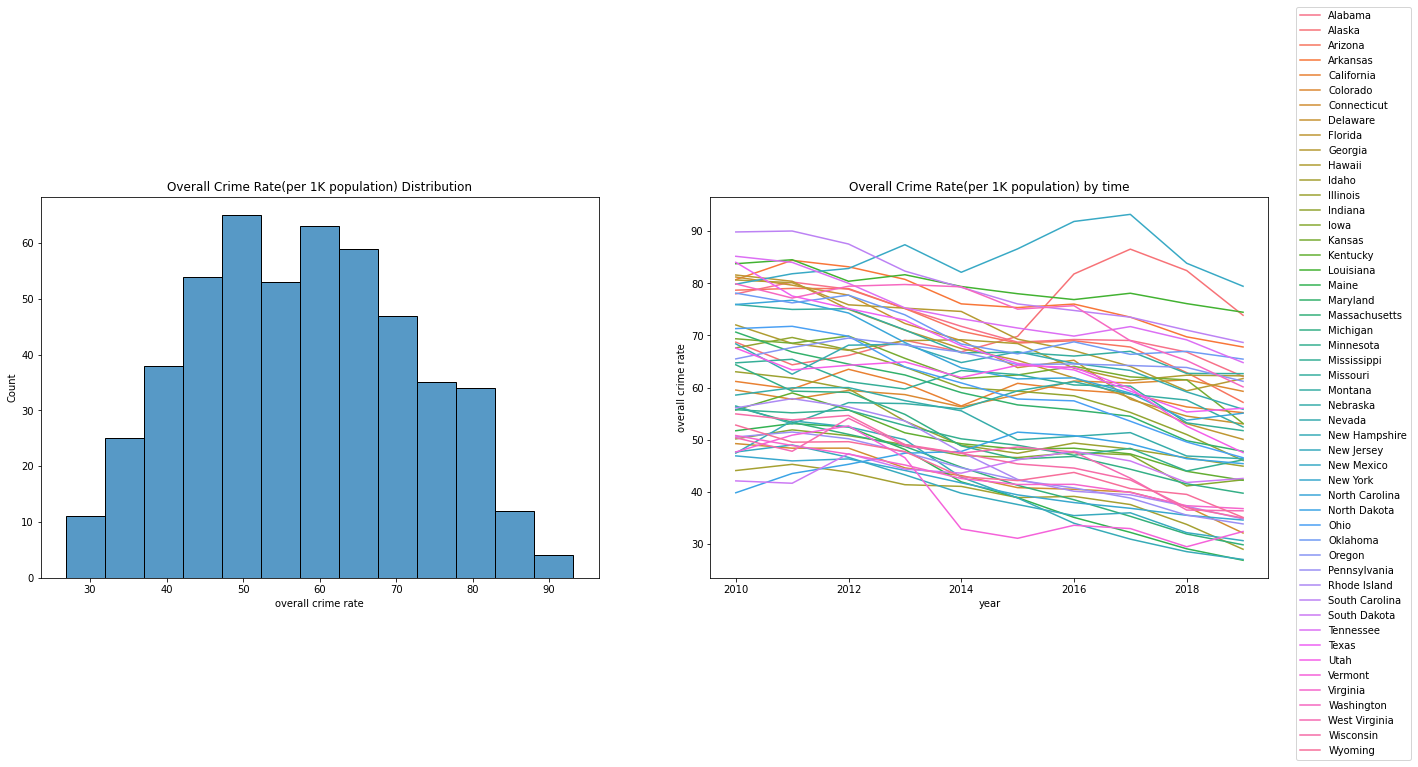

In [4]:
data = merge_data.copy()

fig, axes = plt.subplots(1, 2, figsize=(22, 7))
ax1, ax2 = axes

sns.histplot(data=data, x='overall crime rate', ax=ax1)
ax1.set_title('Overall Crime Rate(per 1K population) Distribution')

sns.lineplot(data=data, x='year', y='overall crime rate', hue='state name', ax=ax2)
ax2.set_title('Overall Crime Rate(per 1K population) by time')

ax2.legend(bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0. )
plt.show()

In [5]:
# preprocess
for c in data.columns:
    dtype = data[c].dtype
    if dtype not in (np.float64, np.int64):
        print(c, dtype)

all_states = data['state name'].unique()
all_states_dict = {s: i for i, s in enumerate(all_states)}
data['state name'] = data['state name'].map(all_states_dict)

state name object


# Task 1

Build a model (or models) to predict the crime rate of the USA

In [6]:
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from collections import defaultdict

def get_Xy(data: pd.DataFrame, drop_year=False):
    if drop_year:
        drop_cols = ['state name', 'year', 'overall crime rate']
    else:
        drop_cols = ['state name', 'overall crime rate']
    input_cols = data.columns[~data.columns.isin(drop_cols)]
    X = data.loc[:, input_cols]
    y = data.loc[:, ['state name', 'year', 'overall crime rate']]
    return X, y

def train(train_data, test_data, params, filename=None, verbose_eval=5, drop_year=False):

    X_train, y_train = get_Xy(train_data, drop_year=drop_year)
    X_test, y_test = get_Xy(test_data, drop_year=drop_year)

    xgb_train = xgb.DMatrix(X_train, label=y_train['overall crime rate'])
    xgb_test = xgb.DMatrix(X_test, label=y_test['overall crime rate'])
    data_dict = {
        'train': (X_train, y_train), 
        'test': (X_test, y_test)
    }
    
    model = xgb.train(params, xgb_train, 40, evals=[(xgb_test, "test")], verbose_eval=verbose_eval)
    model.save_model(model_path / filename)
    print('Train Done')
    return model, data_dict

In [7]:
task_dict = defaultdict(dict)
# start
train_data = data.loc[data['year'] < 2019, :]
test_data = data.loc[data['year'] >= 2019, :]

seed = 8
params = {
    'eta': 0.3,
    'max_depth': 8,
    'objective': 'reg:squarederror',
    'seed': seed
}

model, data_dict = train(train_data, test_data, params, filename='T1.xgb', drop_year=False)

y_true = data_dict['test'][1]['overall crime rate'].values
y_pred = model.predict(xgb.DMatrix(data_dict['test'][0], label=data_dict['test'][1]))

task_dict['T1']['model'] = model
task_dict['T1']['data_dict'] = data_dict

print('Test Results:')
print(f'Mean Squared Error: {mean_squared_error(y_true=y_true, y_pred=y_pred):.4f}')
print(f'R2 Score: {r2_score(y_true=y_true, y_pred=y_pred)}')

[0]	test-rmse:34.76826
[5]	test-rmse:6.37672
[10]	test-rmse:4.22273
[15]	test-rmse:4.26592
[20]	test-rmse:4.34916
[25]	test-rmse:4.38828
[30]	test-rmse:4.37212
[35]	test-rmse:4.37742
[39]	test-rmse:4.38264
Train Done
Test Results:
Mean Squared Error: 19.2075
R2 Score: 0.8940223397313029


In [8]:
df_X, df_y = data_dict['train']
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_X)
shap_interactions = explainer.shap_interaction_values(df_X)

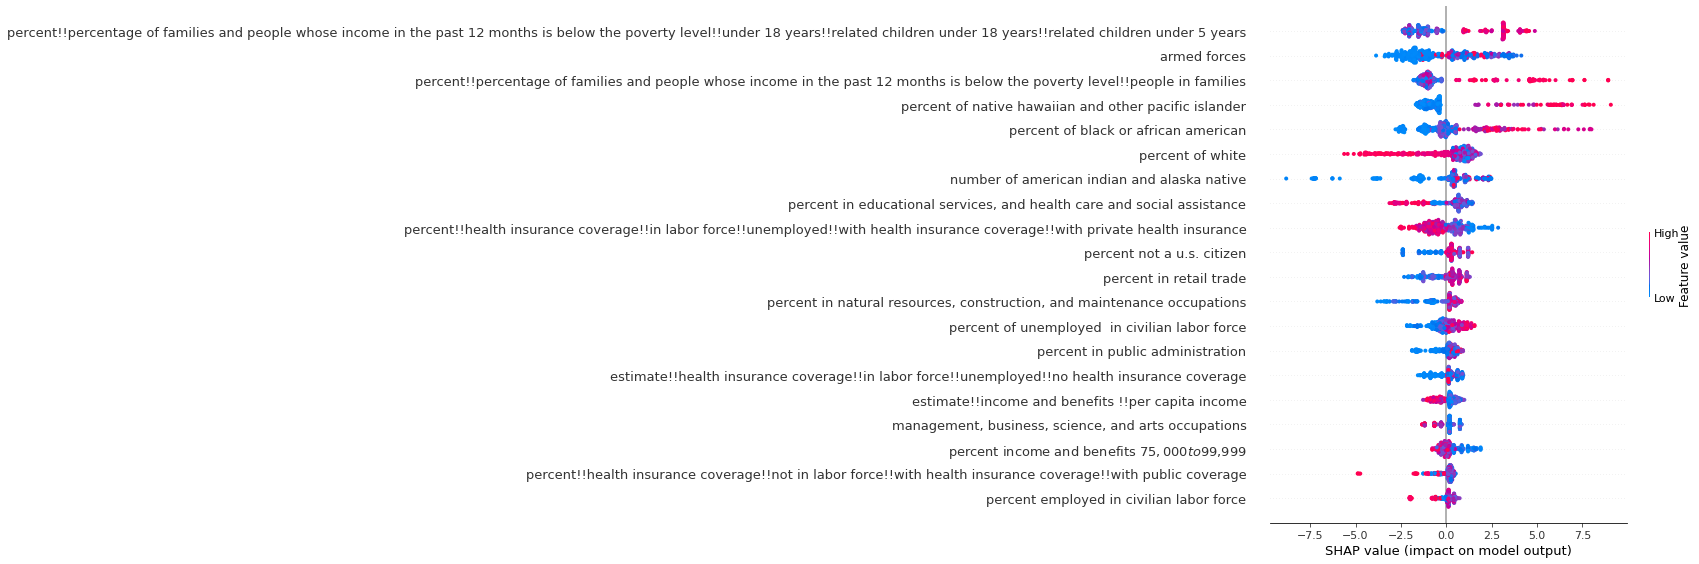

In [9]:
shap.summary_plot(shap_values, df_X, max_display=20)

In [10]:
sv_abs = np.abs(shap_values.values).mean(0)
df_sv_abs = pd.Series(sv_abs, index=df_X.columns).sort_values(ascending=False)

print(df_sv_abs.iloc[:5])
print('...')
print('shap values of year', df_sv_abs.loc['year'], ', (argsort) number of importance:', np.argsort(df_sv_abs)['year'], f'/ {len(sv_abs)}')

percent!!percentage of families and people whose income in the past 12 months is below the poverty level!!under 18 years!!related children under 18 years!!related children under 5 years    1.954656
armed forces                                                                                                                                                                                 1.672785
percent!!percentage of families and people whose income in the past 12 months is below the poverty level!!people in families                                                                 1.578729
percent of native hawaiian and other pacific islander                                                                                                                                        1.492238
percent of black or african american                                                                                                                                                         1.319179
dtype: flo

To estimate the crime rate, the most important feature is the percentage of families and people whose income in the past 12 months is below the poverty level with under 5 years old childrens. Uaually higher percentage has more contributions to higher crime rate. We can observe the year is not an important factor to predict the crime rate.

**Other analysis:**
- negative impact(low crime rate) when the value getting higher, positive impact(high crime rate) when the value getting lower
    - percent of white
    - percent income and benefits 75,000-99,999
    - percent in educational services, and health care and social assitance
    - percentage of unemployed who with private health insurance
    - estimated per capita income
    - percent employed in civilian labor force
- positive impact(high crime rate) when the value getting higher, negative impact(low crime rate) when the value getting lower
    - the percentage of families and people whose income in the past 12 months is below the poverty level with under 5 years old childrens and people in families (some of them are not have positive impact with higher value)
    - percent not a u.s citizen
    - percent in public administration
    - percent of black or african american
    - percent in retail trade
    - percent unemployed in civilian labor force
    - ...

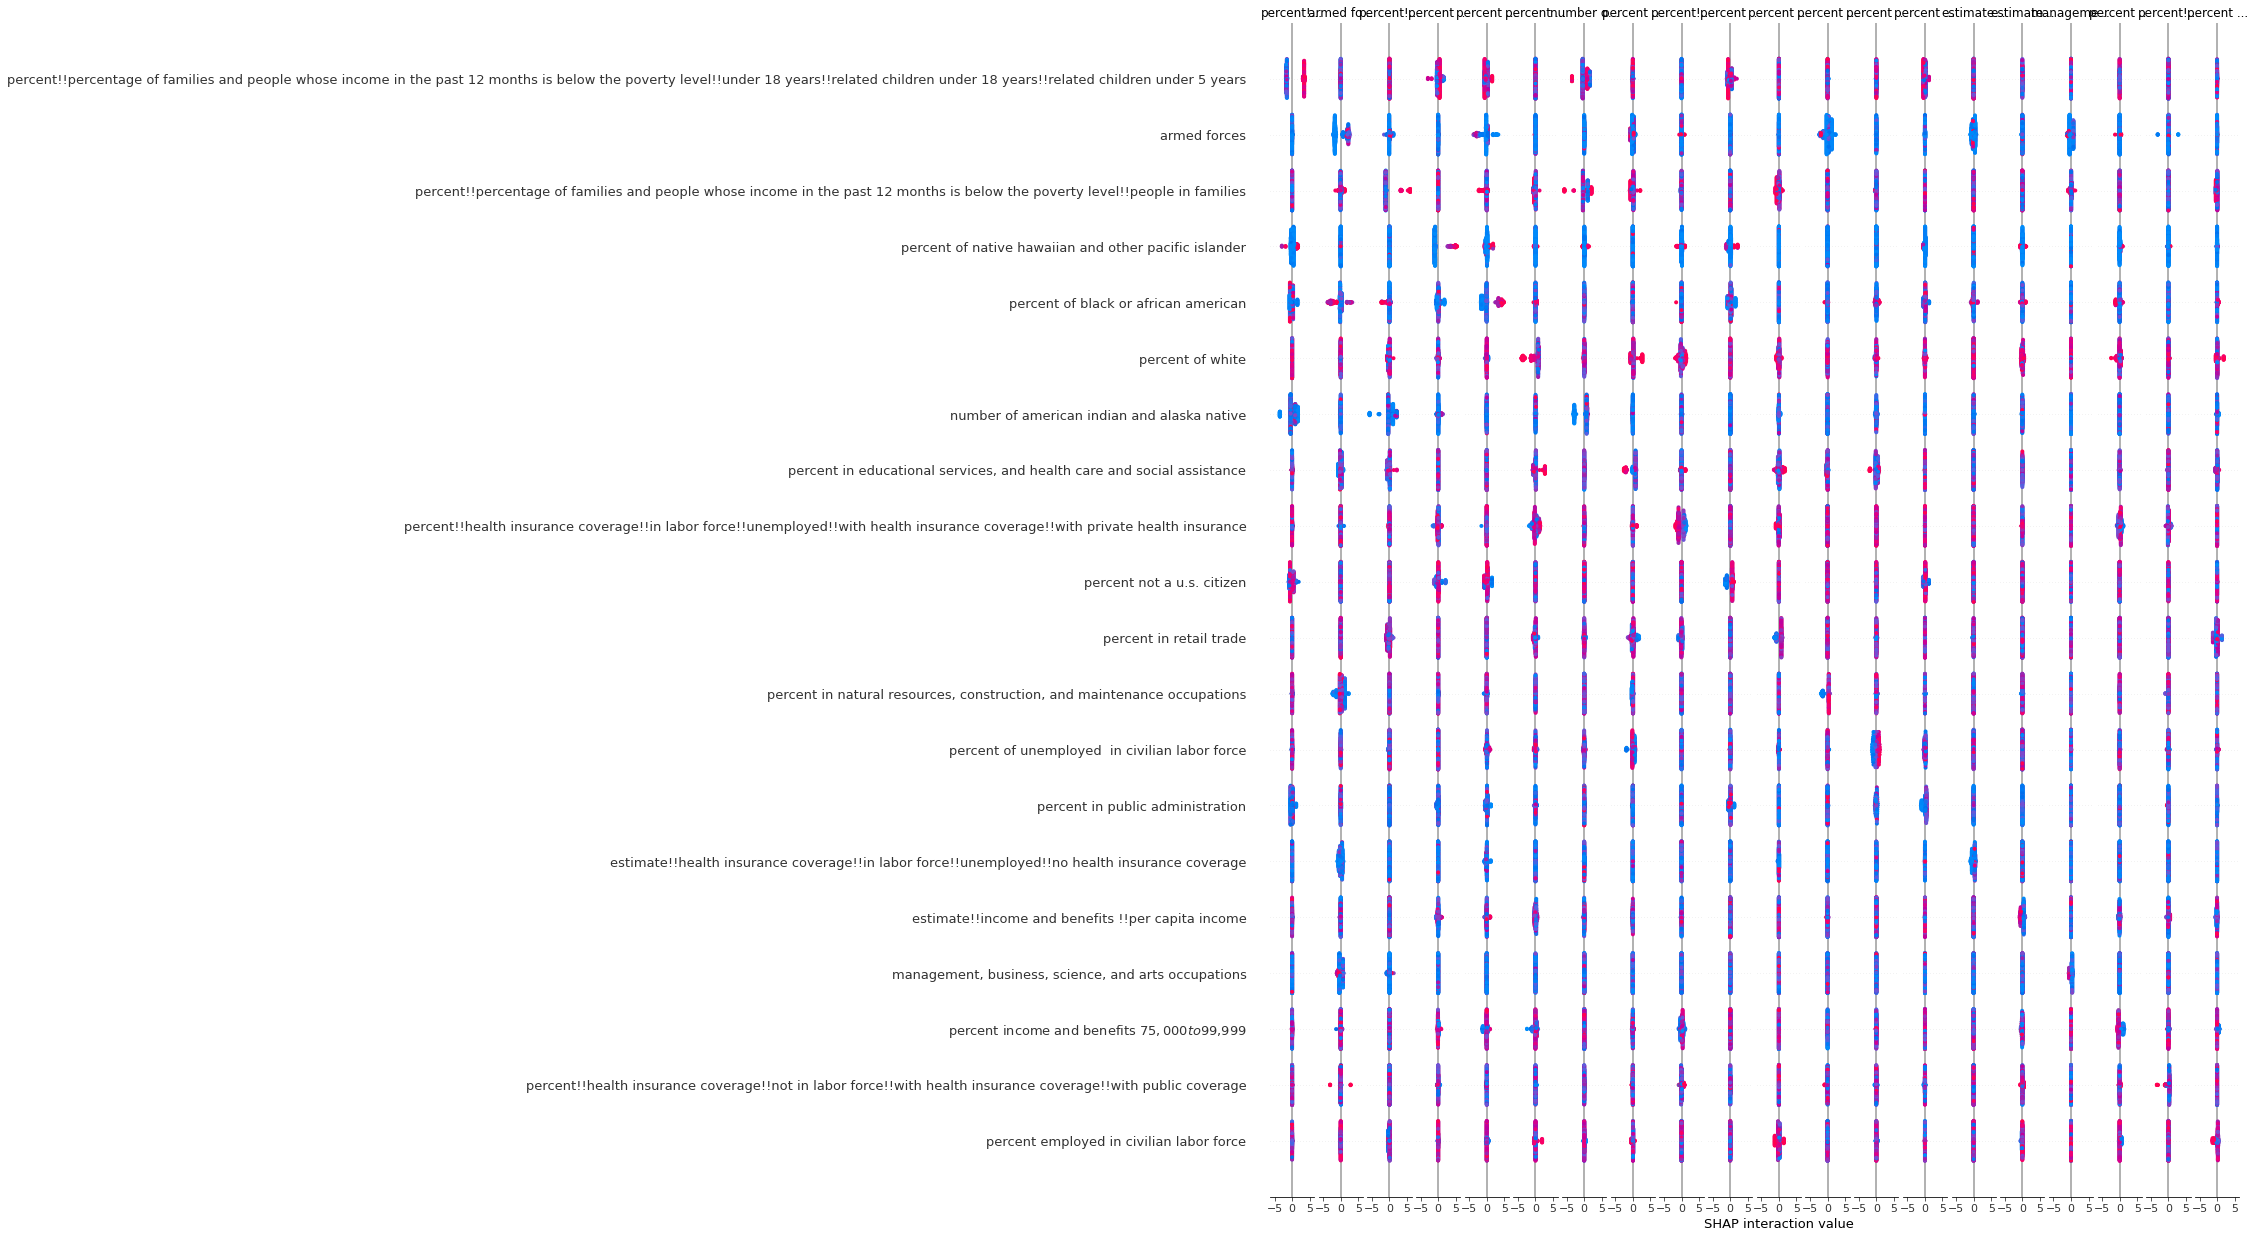

In [11]:
shap.summary_plot(shap_interactions, df_X, max_display=20)

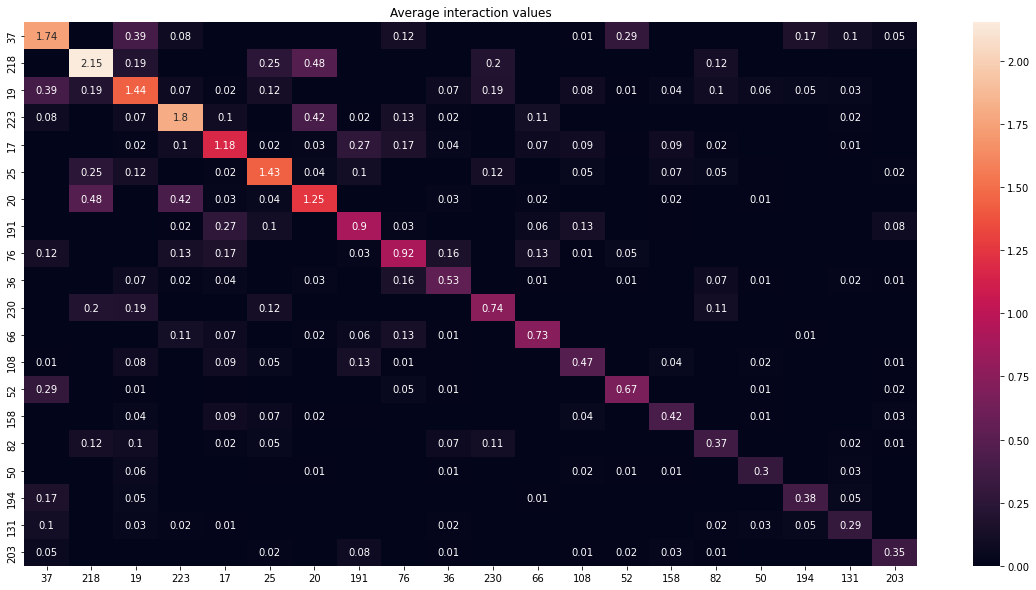

In [12]:
siv_abs = np.abs(shap_interactions).mean(0)
inds = np.argsort(-siv_abs.sum(0))[:20]
siv_abs_sorted = siv_abs[inds,:][:,inds]

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
annotations = siv_abs_sorted.round(2).astype(str)
annotations[siv_abs_sorted < 1e-2] = ""
sns.heatmap(data=pd.DataFrame(siv_abs_sorted, index=inds, columns=inds), annot=annotations, fmt='s', ax=ax)
ax.set_title('Average interaction values')
plt.show()

In [13]:
def batch_tril_indexing(A: np.ndarray, k: int, cols: pd.Index=None, include_main_effect: bool=False):
    rt_pd = False if cols is None else True
    # lower_triangle
    r, c = np.tril_indices(k, -1)
    if include_main_effect:
        r_diag, c_diag = np.diag_indices(k)
        mat = np.concatenate((A[:, r_diag, c_diag], A[:, r, c]), axis=1)
    else:
        mat = A[:, r, c]
    
    if rt_pd:
        cs = list(map(lambda x: f'{x[0]}({x[2]})+{x[1]}({x[3]})', zip(*(cols[r], cols[c], r, c))))
        if include_main_effect:
            cs = list(cols) + cs
        return pd.DataFrame(mat, columns=cs)
    else:
        return mat

We can see some of features have the interactions with others from the interaction figures, "number of american indian and alaska native" has some interaction with "percentage of families and people whose income in the past 12 months is below the poverty level related children under 5 years", and "percentage of families and people whose income in the past 12 months is below the poverty level related to people in families" and so on.

In [14]:
# top 5 interaction impact between two features
siv_dense = batch_tril_indexing(shap_interactions, k=len(df_X.columns), cols=df_X.columns, include_main_effect=False)
siv_abs_sorted = np.abs(siv_dense).mean(0).sort_values(ascending=False)
print('top 5 interaction impact between two features:')
print(siv_abs_sorted[:5])

top 5 interaction impact between two features:
percent!!percentage of families and people whose income in the past 12 months is below the poverty level!!under 18 years!!related children under 18 years!!related children under 5 years(218)+number of american indian and alaska native(20)    0.475588
percent!!percentage of families and people whose income in the past 12 months is below the poverty level!!people in families(223)+number of american indian and alaska native(20)                                                                 0.419539
armed forces(37)+percent of black or african american(19)                                                                                                                                                                                         0.394489
percent in natural resources, construction, and maintenance occupations(52)+armed forces(37)                                                                                                            

However year has not that much interaction between other features

In [15]:
siv_abs_sorted.loc[['year(0)' in l for l in siv_abs_sorted.index.str.split('+').values]][:10]

percent of single mothers/fathers(225)+year(0)                                                                                                                 0.038598
estimate!!income and benefits !!with cash public assistance income!!mean cash public assistance income(131)+year(0)                                            0.028660
percent self-employed in own not incorporated business workers(90)+year(0)                                                                                     0.021979
percent!!percentage of families and people whose income in the past 12 months is below the poverty level!!18 years and over!!65 years and over(222)+year(0)    0.017733
percent in arts, entertainment, and recreation, and accommodation and food services(78)+year(0)                                                                0.017364
armed forces(37)+year(0)                                                                                                                                       0

In [16]:
all_siv_dict = defaultdict()
years = np.array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
states = list(all_states_dict.values())
for c in states:
    c_idx = df_y.loc[df_y['state name'] == c].index
    df_c = df_X.loc[c_idx]

    siv = explainer.shap_interaction_values(df_c)
    r_idx, c_idx = np.diag_indices(siv.shape[1])
    siv_main_abs = np.abs(siv[:, r_idx, c_idx])
    idx_main_sorted = pd.DataFrame(np.argsort(-siv_main_abs, axis=1), columns=df_c.columns)
    
    siv_dense = batch_tril_indexing(siv, k=len(df_c.columns), cols=df_c.columns, include_main_effect=False)
    year_cols = siv_dense.columns[['year(0)' in l for l in siv_dense.columns.str.split('+').values]]
    siv_abs = np.abs(siv_dense.loc[:, year_cols])
    idx_sorted = np.argsort(-siv_abs, axis=1)
    
    sivs = pd.DataFrame([(
            years[i], 
            idx_main_sorted.loc[i, 'year'],
            siv[i, 0, 0],
            siv[i, 0, 1:].sum(),
            np.take_along_axis(siv_abs.columns, s, axis=0)[0].replace('+year(0)', '').replace('year(0)+', ''), 
            np.take_along_axis(siv_dense.loc[:, year_cols].values[i], s, axis=0)[0],
        ) for i, s in idx_sorted.iterrows()], columns=['year', 'ranking_of_year', 'main_effect', 'interaction', 'highest_col', 'highest_interaction'])

    all_siv_dict[c] = sivs

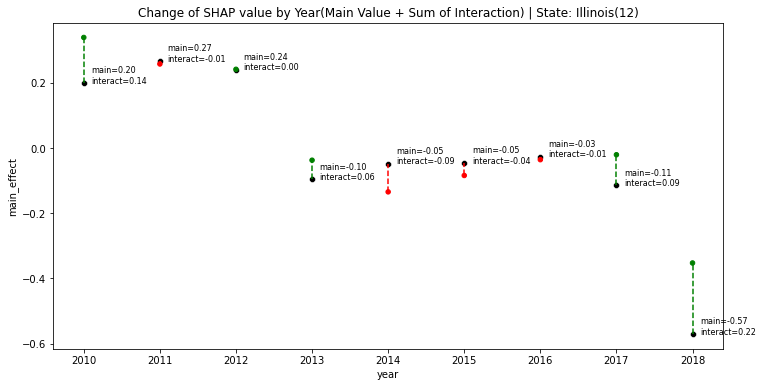

In [17]:
c = 12 # np.random.choice(states)
c_name = list(all_states_dict.keys())[c]
df_siv = all_siv_dict[c].copy()
df_siv['effect'] = df_siv['main_effect'] + df_siv['interaction']
df_siv['color'] = (df_siv['effect'] > df_siv['main_effect']).map({True: 'g', False: 'r'})
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.scatterplot(data=df_siv, x='year', y='main_effect', color='k', ax=ax)

ax.scatter(x=df_siv['year'], y=df_siv['effect'], s=20, c=df_siv['color'].values)

for k, (x, y1, y2) in enumerate(zip(df_siv['year'], df_siv['main_effect'], df_siv['effect'])):
    ax.vlines(x=x, ymin=min([y1, y2]), ymax=max([y1, y2]), colors=df_siv['color'][k], linestyles='dashed')

for x, y, m, i in zip(df_siv['year'], df_siv['main_effect'], df_siv['main_effect'], df_siv['interaction']):
    ax.text(x+0.1, y, s=f'main={m:.2f}\ninteract={i:.2f}', fontsize=8)

ax.set_title(f'Change of SHAP value by Year(Main Value + Sum of Interaction) | State: {c_name}({c})')
plt.show()

In [18]:
df_siv

year  ranking_of_year  main_effect  interaction  \
0  2010              218     0.198829     0.140212   
1  2011               37     0.267010    -0.009292   
2  2012               37     0.240529     0.000886   
3  2013               37    -0.096587     0.059141   
4  2014               37    -0.048660    -0.085935   
5  2015               37    -0.046466    -0.037855   
6  2016               37    -0.027052    -0.008811   
7  2017               37    -0.114664     0.093966   
8  2018              218    -0.570505     0.217776   

                                         highest_col  highest_interaction  \
0        percent in sales and office occupations(50)             0.081510   
1        percent in sales and office occupations(50)             0.056864   
2        percent in sales and office occupations(50)             0.050490   
3  percent!!percentage of families and people who...             0.025310   
4  estimate!!income and benefits !!$50,000 to $74...            -0.043128   
5  estimate!!income and benefits !!$50,000 to $74...            -0.043128   
6  percent in arts, entertainment, and recreation...            -0.022552   
7  percent!!percentage of families and people who...             0.027309   
8  estimate!!income and benefits !!with cash publ...             0.187353   

     effect color  
0  0.339041     g  
1  0.257718     r  
2  0.241415     g  
3 -0.037446     g  
4 -0.134595     r  
5 -0.084321     r  
6 -0.035863     r  
7 -0.020698     g  
8 -0.352729     g

# Task 2

Select five states with different profiles in demography, economy, and social characteristics, build a model (or models) to predict the crime rate of these five states separately

In [30]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

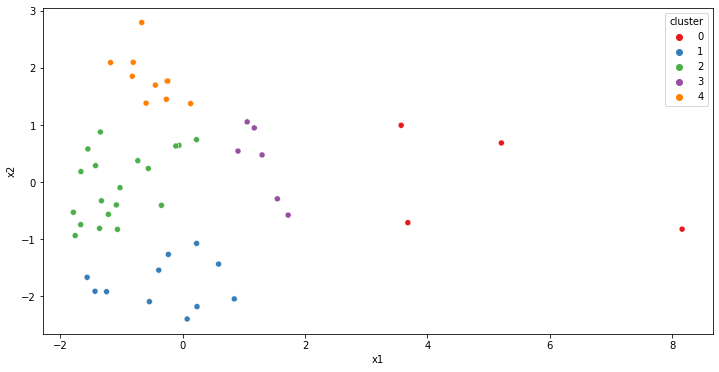

In [38]:
# use Kmeans to create 5 clusters to see the difference profiles
char_scaled = MinMaxScaler(range(-1, 1)).fit_transform(char_data)

# dim_reducer = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=seed)
dim_reducer = PCA(n_components=2)
char_reduced = dim_reducer.fit_transform(char_scaled)
# aggregate with year for each state
char_reduced = pd.DataFrame(char_reduced, index=char_data.index, columns=['x1', 'x2'])\
    .reset_index().groupby(['state name'])[['x1', 'x2']].mean()

cluster_constructor = AgglomerativeClustering(n_clusters=5)
# cluster_constructor = KMeans(n_clusters=5)
cluster_constructor.fit(char_reduced)

clusters = cluster_constructor.labels_

df_clusters = pd.DataFrame(np.concatenate([char_reduced, clusters[:, np.newaxis]], axis=1), 
    index=char_reduced.index, columns=['x1', 'x2', 'cluster']).reset_index().rename(columns={'state name': 'state'})
df_clusters['cluster'] = df_clusters['cluster'].astype(np.int32)
df_clusters['state name'] = df_clusters.reset_index()['state'].map(all_states_dict)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(x='x1', y='x2', palette='Set1', hue='cluster', data=df_clusters, ax=ax)
plt.show()

In [39]:
all_cs = {}
t = 0
for c in range(5):
    cs = df_clusters.loc[df_clusters['cluster'] == c, 'state name'].values
    print(f'Cluster: {c}(#={len(cs)}) {cs}')
    all_cs[c] = cs
    t += len(cs)
print(f'Total = {t}')

Cluster: 0(#=4) [ 4  8 31 42]
Cluster: 1(#=11) [ 1  5  6 10 19 20 22 28 29 45 46]
Cluster: 2(#=19) [ 2  7 11 13 14 15 18 24 25 26 27 33 36 38 40 43 44 48 49]
Cluster: 3(#=6) [ 9 12 21 32 34 37]
Cluster: 4(#=10) [ 0  3 16 17 23 30 35 39 41 47]
Total = 50


In [40]:
np.random.seed(seed)
selected_states = []
for c in range(5):
    idx = np.random.choice(all_cs[c])
    selected_states.append(idx)
print(f'Selected in each cluster: {selected_states}')

Selected in each cluster: [42, 19, 48, 12, 30]


In [41]:
train_data_sep = data.loc[data['state name'].isin(selected_states) & (data['year'] < 2019), :]
test_data_sep = data.loc[data['state name'].isin(selected_states) & (data['year'] >= 2019), :]

In [42]:
model, data_dict = train(train_data_sep, test_data_sep, params, filename='T2.xgb', verbose_eval=10, drop_year=False)

y_true = data_dict['test'][1]['overall crime rate'].values
y_pred = model.predict(xgb.DMatrix(data_dict['test'][0], label=data_dict['test'][1]))

task_dict[f'T2']['model'] = model
task_dict[f'T2']['data_dict'] = data_dict

print(f'Test Results:')
print(f'Mean Squared Error: {mean_squared_error(y_true=y_true, y_pred=y_pred):.4f}')
print(f'R2 Score: {r2_score(y_true=y_true, y_pred=y_pred)}')

[0]	test-rmse:37.45724
[10]	test-rmse:4.16342
[20]	test-rmse:2.53532
[30]	test-rmse:2.56755
[39]	test-rmse:2.56866
Train Done
Test Results:
Mean Squared Error: 6.5980
R2 Score: 0.9706132351403205


In [43]:
df_X, df_y = data_dict['train']
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_X)
shap_interactions = explainer.shap_interaction_values(df_X)

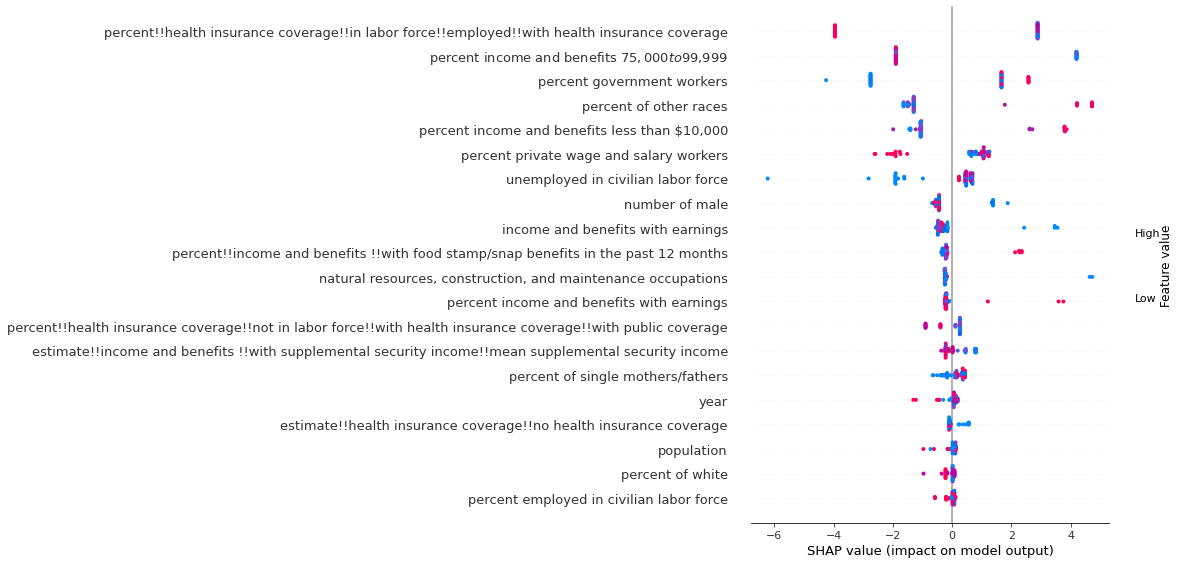

In [44]:
shap.summary_plot(shap_values, df_X)

In [45]:
sv_abs = np.abs(shap_values.values).mean(0)
df_sv_abs = pd.Series(sv_abs, index=df_X.columns).sort_values(ascending=False)

print(df_sv_abs.iloc[:5])
print('...')
print('shap values of year', df_sv_abs.loc['year'], ', (argsort) number of importance:', np.argsort(df_sv_abs)['year'], f'/ {len(sv_abs)}')

percent!!health insurance coverage!!in labor force!!employed!!with health insurance coverage    3.338563
percent income and benefits $75,000 to $99,999                                                  2.613674
percent government workers                                                                      2.273072
percent of other races                                                                          2.100608
percent income and benefits less than $10,000                                                   1.778571
dtype: float32
...
shap values of year 0.17965029 , (argsort) number of importance: 161 / 232


To estimate the crime rate with a single model with 5 states(in different clusters), the most important feature is health insurance coverage(health insurance). Higher percentage(usually higher coverage) has a huge negative contributions to higher crime rate. 

**Other analysis:**
- negative impact(low crime rate) when the value getting higher, positive impact(high crime rate) when the value getting lower
    - percent income and benefits 75,000-99,999
    - percent private wage and salary workers
    - percent of white
    - mean supplement income
    - ...
- positive impact(high crime rate) when the value getting higher, negative impact(low crime rate) when the value getting lower
    - percent government workers
    - percent of other workers
    - ...


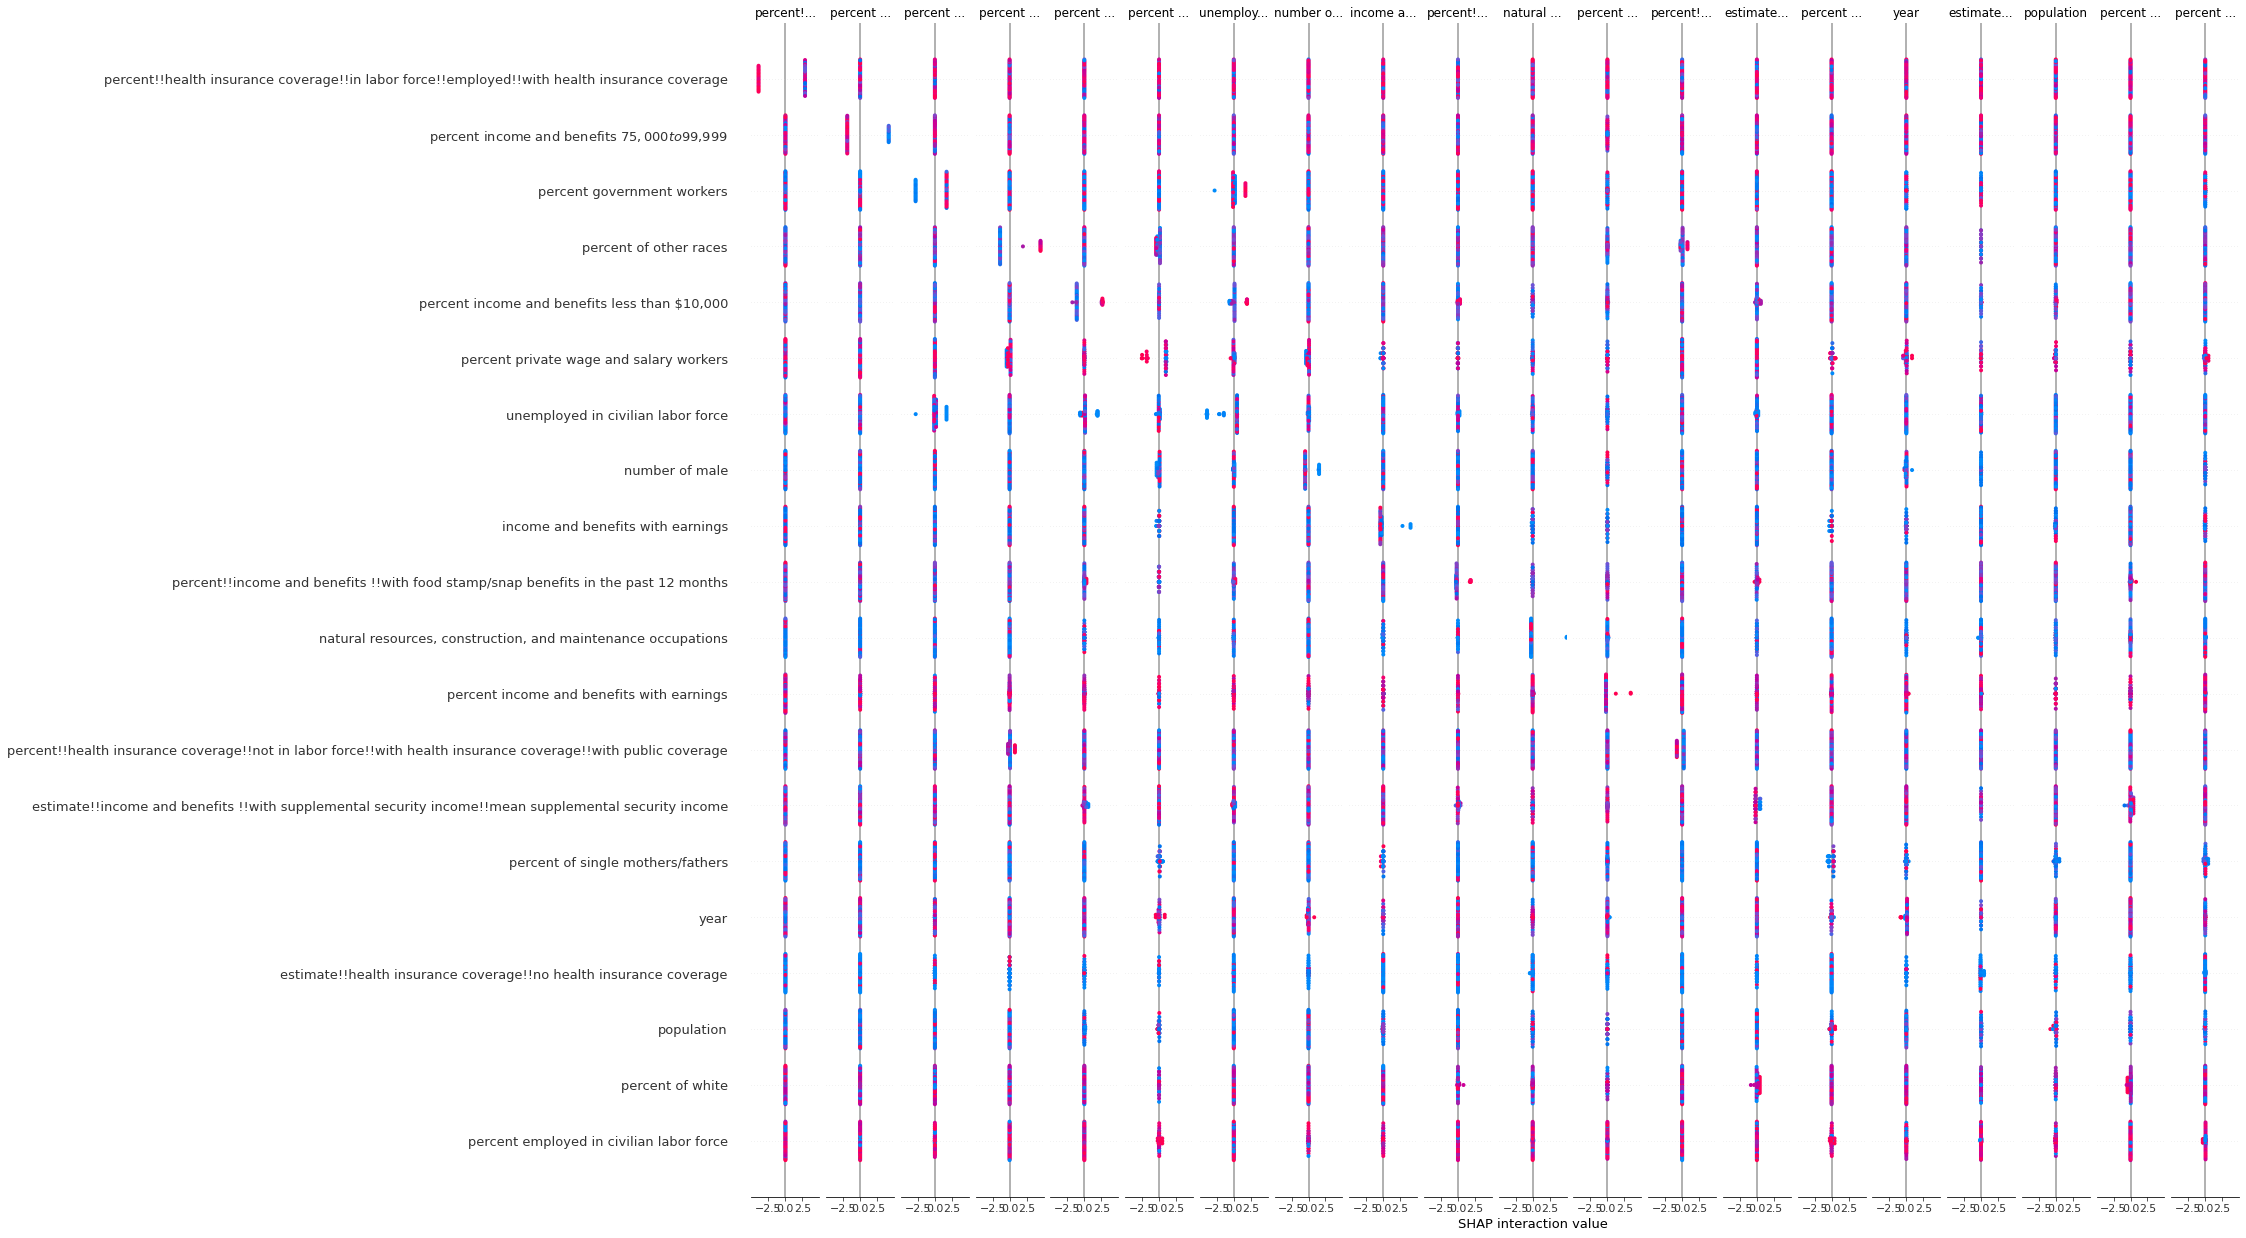

In [46]:
shap.summary_plot(shap_interactions, df_X, max_display=20)

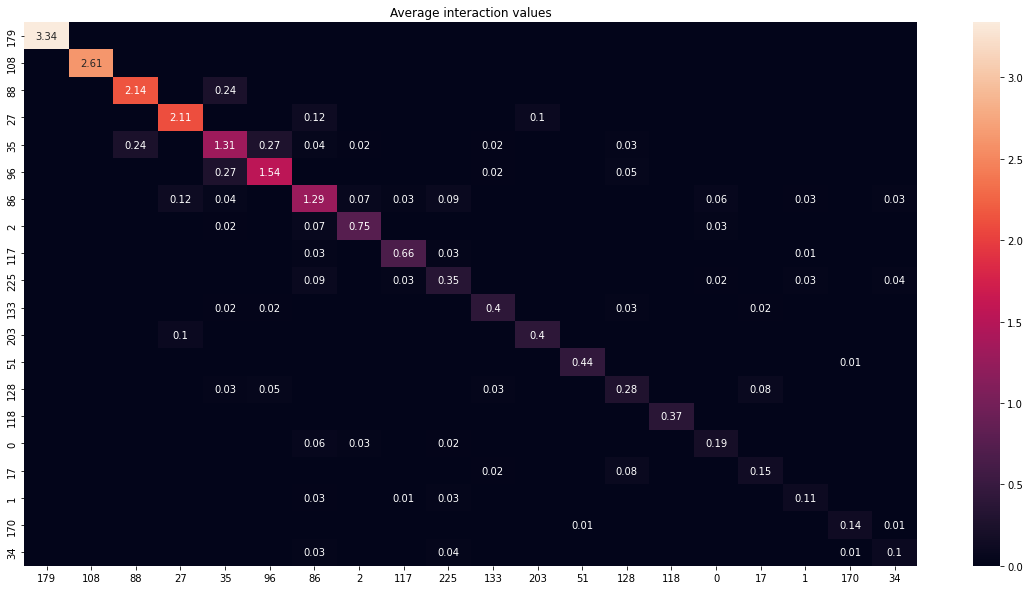

In [47]:
siv_abs = np.abs(shap_interactions).mean(0)
inds = np.argsort(-siv_abs.sum(0))[:20]
siv_abs_sorted = siv_abs[inds,:][:,inds]

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
annotations = siv_abs_sorted.round(2).astype(str)
annotations[siv_abs_sorted < 1e-2] = ""
sns.heatmap(data=pd.DataFrame(siv_abs_sorted, index=inds, columns=inds), annot=annotations, fmt='s', ax=ax)
ax.set_title('Average interaction values')
plt.show()

We can see some of features have the interactions with others from the interaction figures and following columns

In [48]:
# top 5 interaction impact between two features
siv_dense = batch_tril_indexing(shap_interactions, k=len(df_X.columns), cols=df_X.columns, include_main_effect=False)
siv_abs_sorted = np.abs(siv_dense).mean(0).sort_values(ascending=False)
print('top 5 interaction impact between two features:')
print(siv_abs_sorted[:5])

top 5 interaction impact between two features:
percent income and benefits less than $10,000(96)+unemployed in civilian labor force(35)                                                        0.270743
percent government workers(88)+unemployed in civilian labor force(35)                                                                           0.238937
percent private wage and salary workers(86)+percent of other races(27)                                                                          0.121171
percent!!health insurance coverage!!not in labor force!!with health insurance coverage!!with public coverage(203)+percent of other races(27)    0.102217
percent of single mothers/fathers(225)+percent private wage and salary workers(86)                                                              0.085538
dtype: float32


This time has lower interaction between other features.

In [49]:
siv_abs_sorted.loc[['year(0)' in l for l in siv_abs_sorted.index.str.split('+').values]][:10]

percent private wage and salary workers(86)+year(0)                         0.057331
number of male(2)+year(0)                                                   0.034360
percent of single mothers/fathers(225)+year(0)                              0.021211
percent in other services, except public administration(80)+year(0)         0.009485
percent income and benefits with earnings(118)+year(0)                      0.008751
other services, except public administration(79)+year(0)                    0.008051
income and benefits with earnings(117)+year(0)                              0.006954
percent of unemployed  in civilian labor force(36)+year(0)                  0.000900
population(1)+year(0)                                                       0.000612
natural resources, construction, and maintenance occupations(51)+year(0)    0.000415
dtype: float32

In [50]:
# seperate models
shap_dict = defaultdict(dict)
results = []
for i in range(len(selected_states)):
    state = selected_states[i]
    train_valid_data = train_data_sep.loc[train_data_sep['state name'] == state]
    test_data = test_data_sep.loc[test_data_sep['state name'] == state]
    model, data_dict = train(train_valid_data, test_data, params, filename=f'T2.{state}.xgb', verbose_eval=20)

    y_true = data_dict['test'][1]['overall crime rate'].values
    y_pred = model.predict(xgb.DMatrix(data_dict['test'][0], label=data_dict['test'][1]))
    
    task_dict[f'T2.{state}']['model'] = model
    task_dict[f'T2.{state}']['data_dict'] = data_dict
    
    results.append((y_true, y_pred))

    df_X, df_y = data_dict['train']
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(df_X)
    shap_interactions = explainer.shap_interaction_values(df_X)
    shap_dict[state]['explainer'] = explainer
    shap_dict[state]['df_X'] = df_X
    shap_dict[state]['shap_values'] = shap_values
    shap_dict[state]['shap_interactions'] = shap_interactions

y_true, y_pred = map(lambda x: np.array(x).squeeze(), zip(*results))
print(f'Test Results {state}:')
print(f'Mean Squared Error: {mean_squared_error(y_true=y_true, y_pred=y_pred):.4f}')
print(f'R2 Score: {r2_score(y_true=y_true, y_pred=y_pred)}')

[0]	test-rmse:37.04917
[20]	test-rmse:0.44399
[39]	test-rmse:0.23386
Train Done
[0]	test-rmse:31.20643
[20]	test-rmse:1.99099
[39]	test-rmse:2.02367
Train Done
[0]	test-rmse:21.76082
[20]	test-rmse:2.04341
[39]	test-rmse:2.05831
Train Done
[0]	test-rmse:30.20508
[20]	test-rmse:3.31298
[39]	test-rmse:3.40877
Train Done
[0]	test-rmse:55.96806
[20]	test-rmse:9.30907
[39]	test-rmse:10.66908
Train Done
Test Results 30:
Mean Squared Error: 26.7671
R2 Score: 0.8807825140347265


In [51]:
selected_states

[42, 19, 48, 12, 30]

Texas


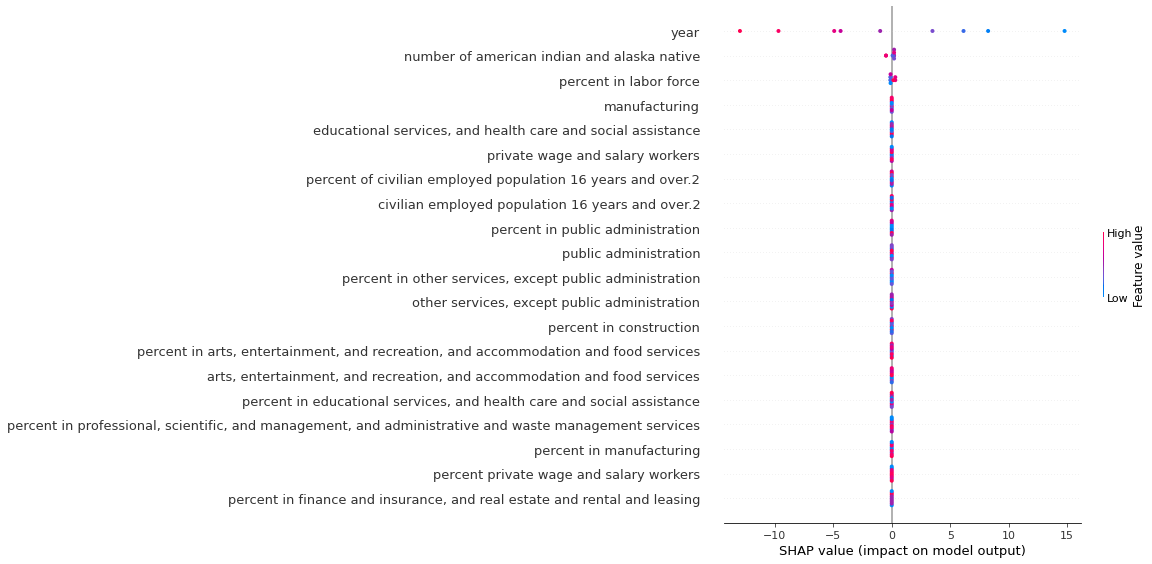

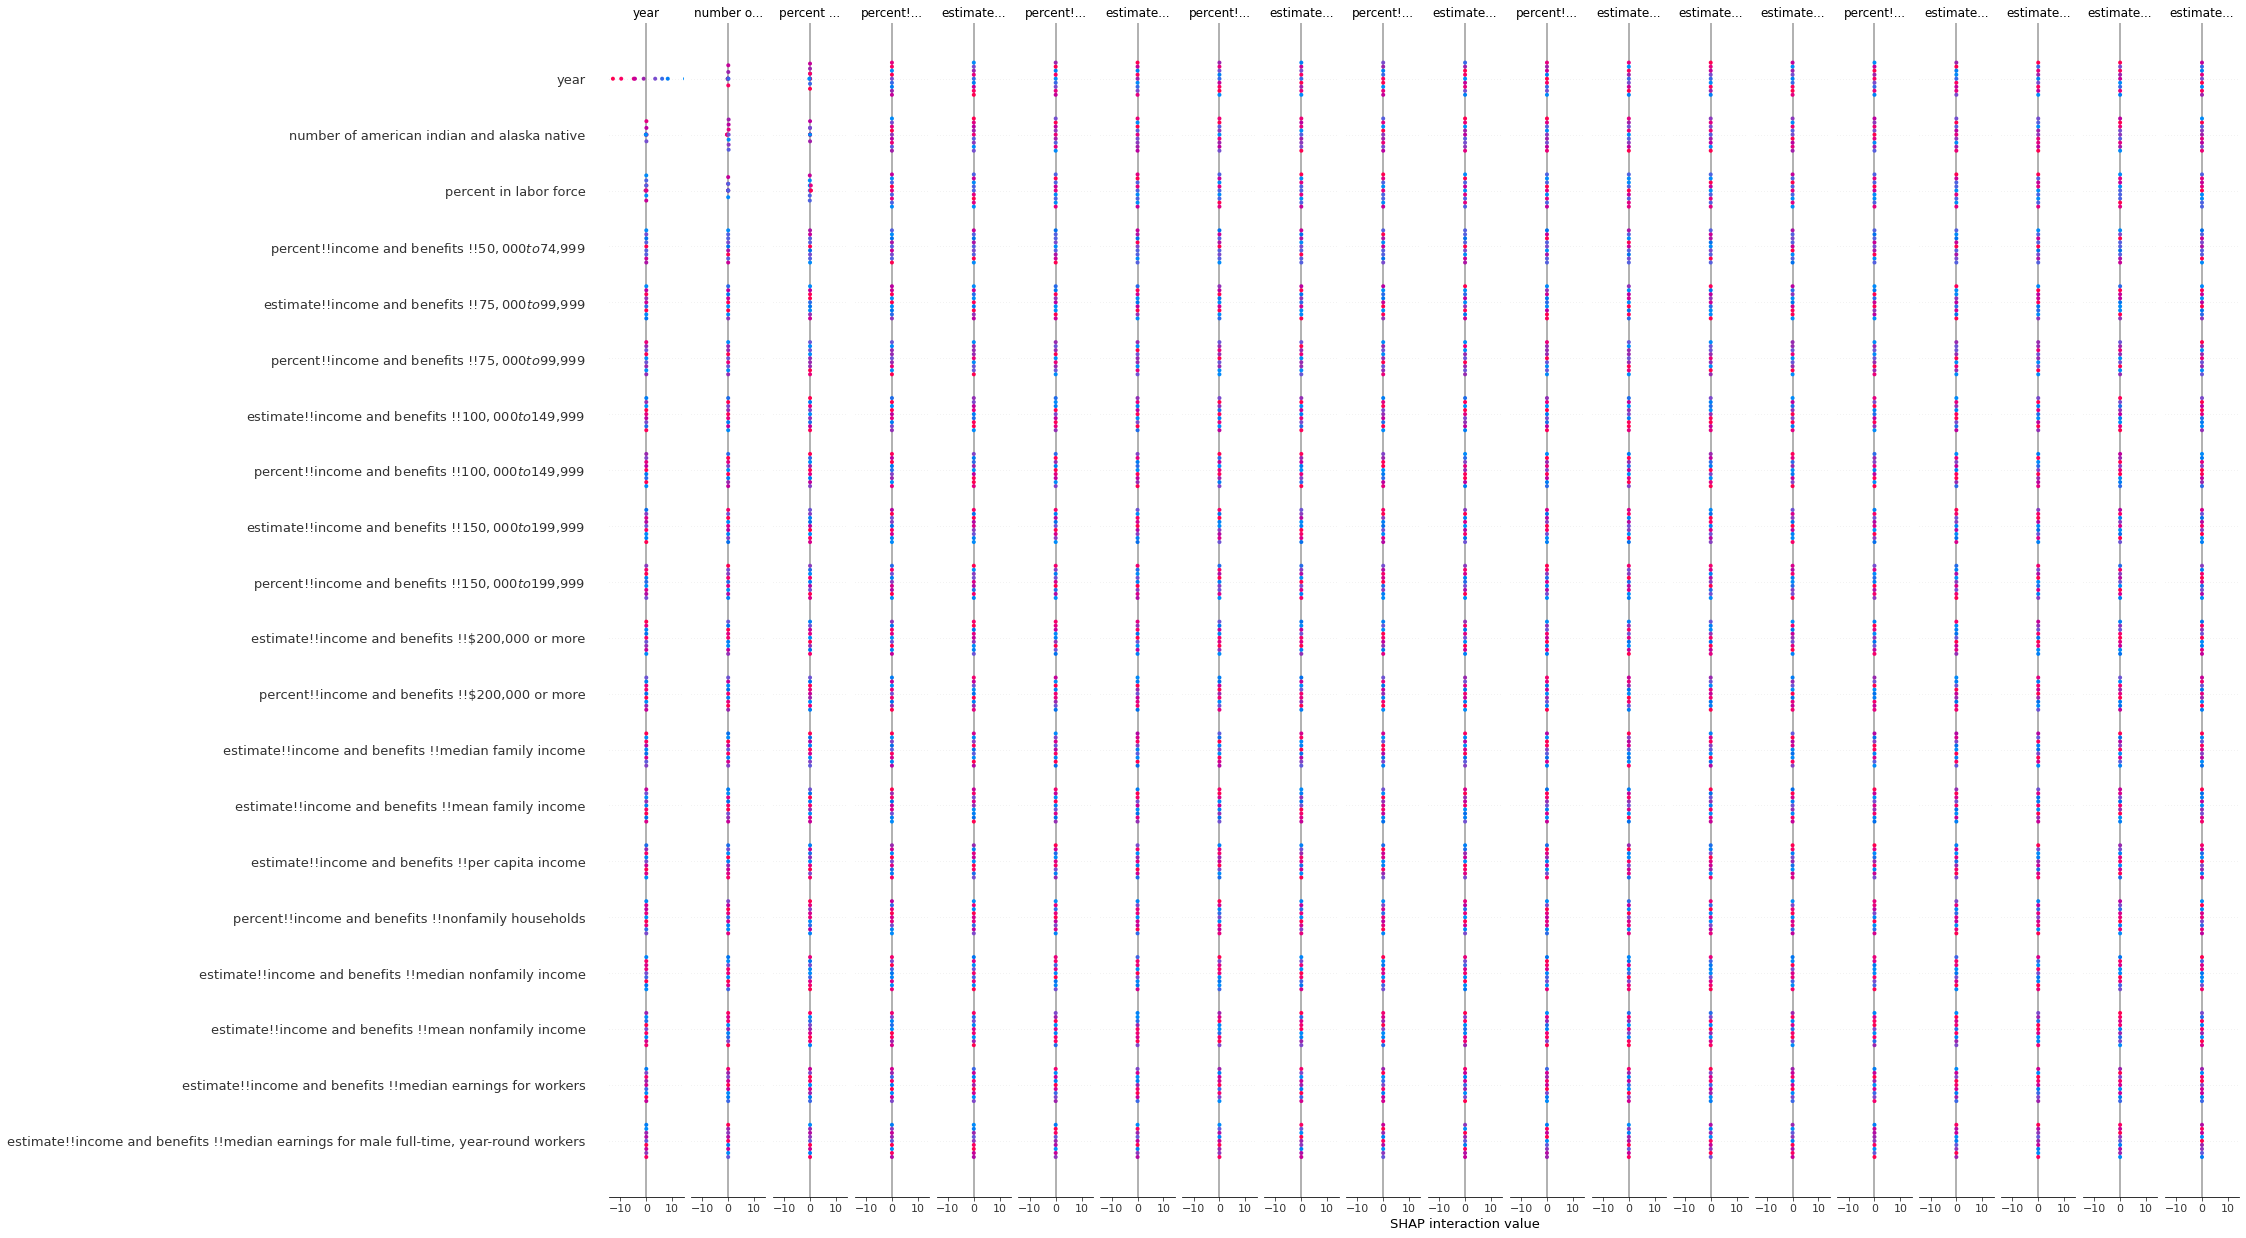

In [52]:
state = selected_states[0]
print(f'{list(all_states_dict.keys())[state]}')
shap.summary_plot(shap_dict[state]['shap_values'])
shap.summary_plot(shap_dict[state]['shap_interactions'], shap_dict[state]['df_X'], max_display=20)

Maryland


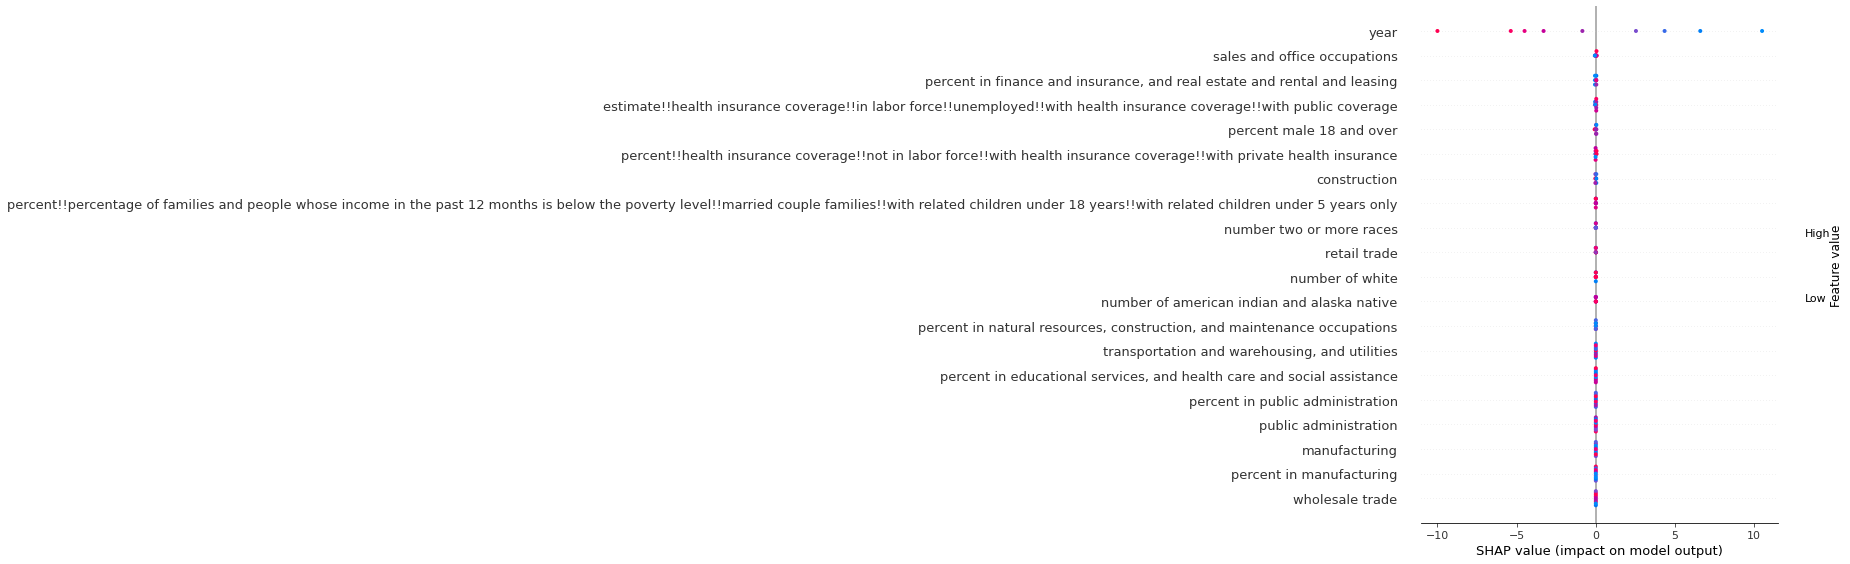

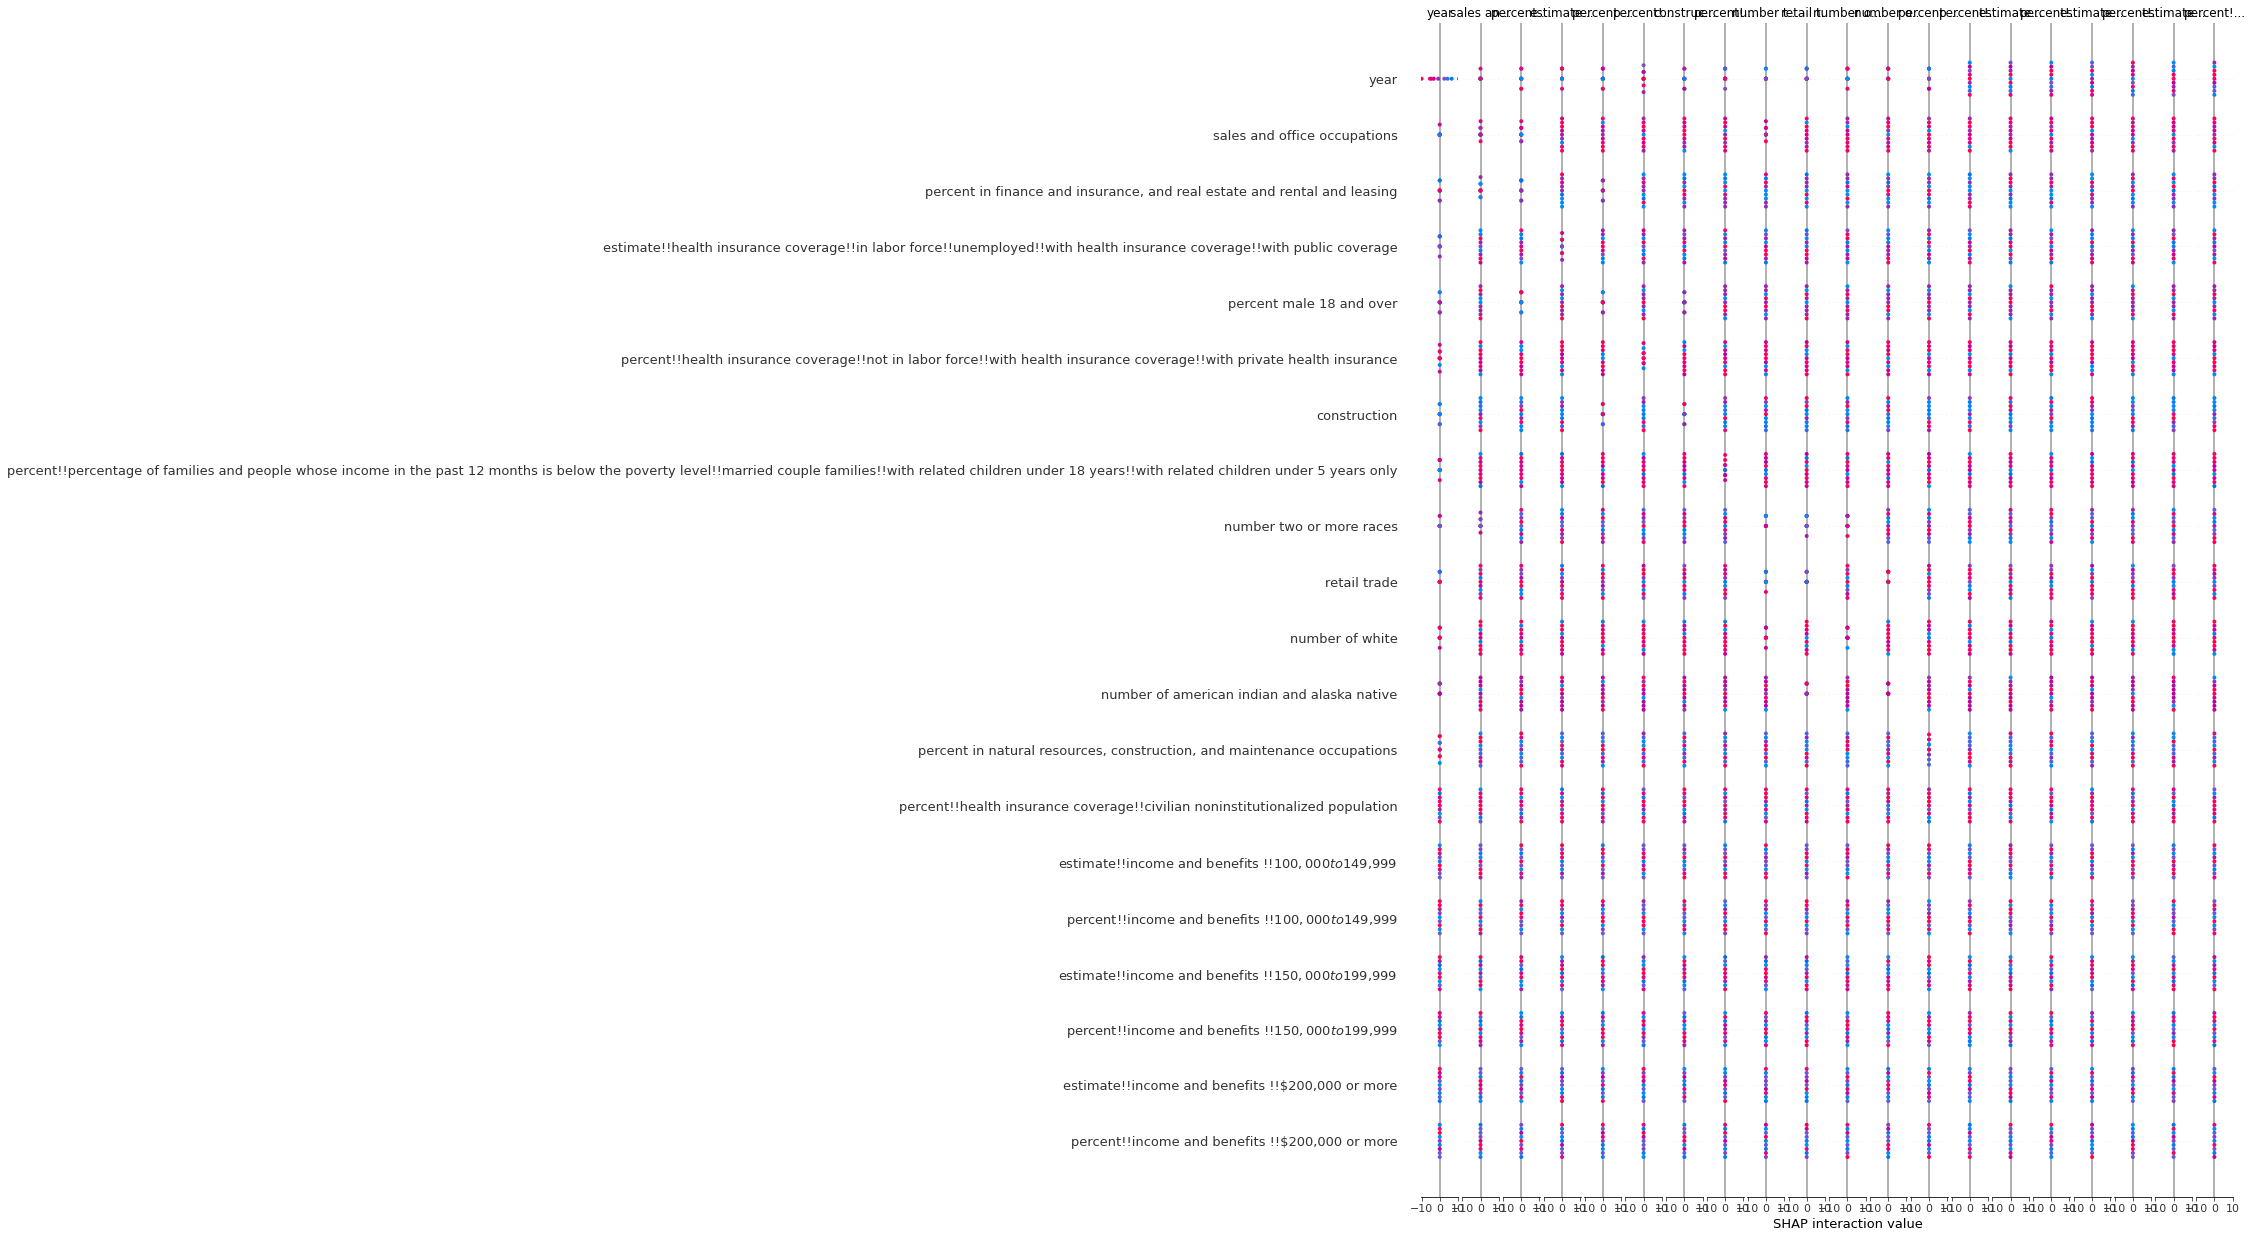

In [53]:
state = selected_states[1]
print(f'{list(all_states_dict.keys())[state]}')
shap.summary_plot(shap_dict[state]['shap_values'])
shap.summary_plot(shap_dict[state]['shap_interactions'], shap_dict[state]['df_X'], max_display=20)

Wisconsin


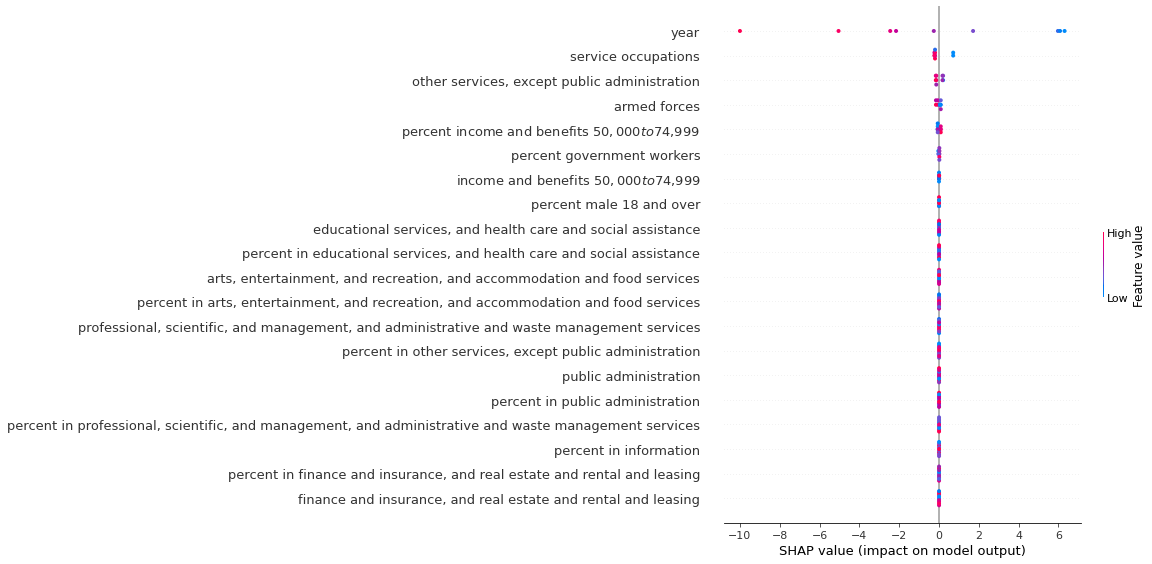

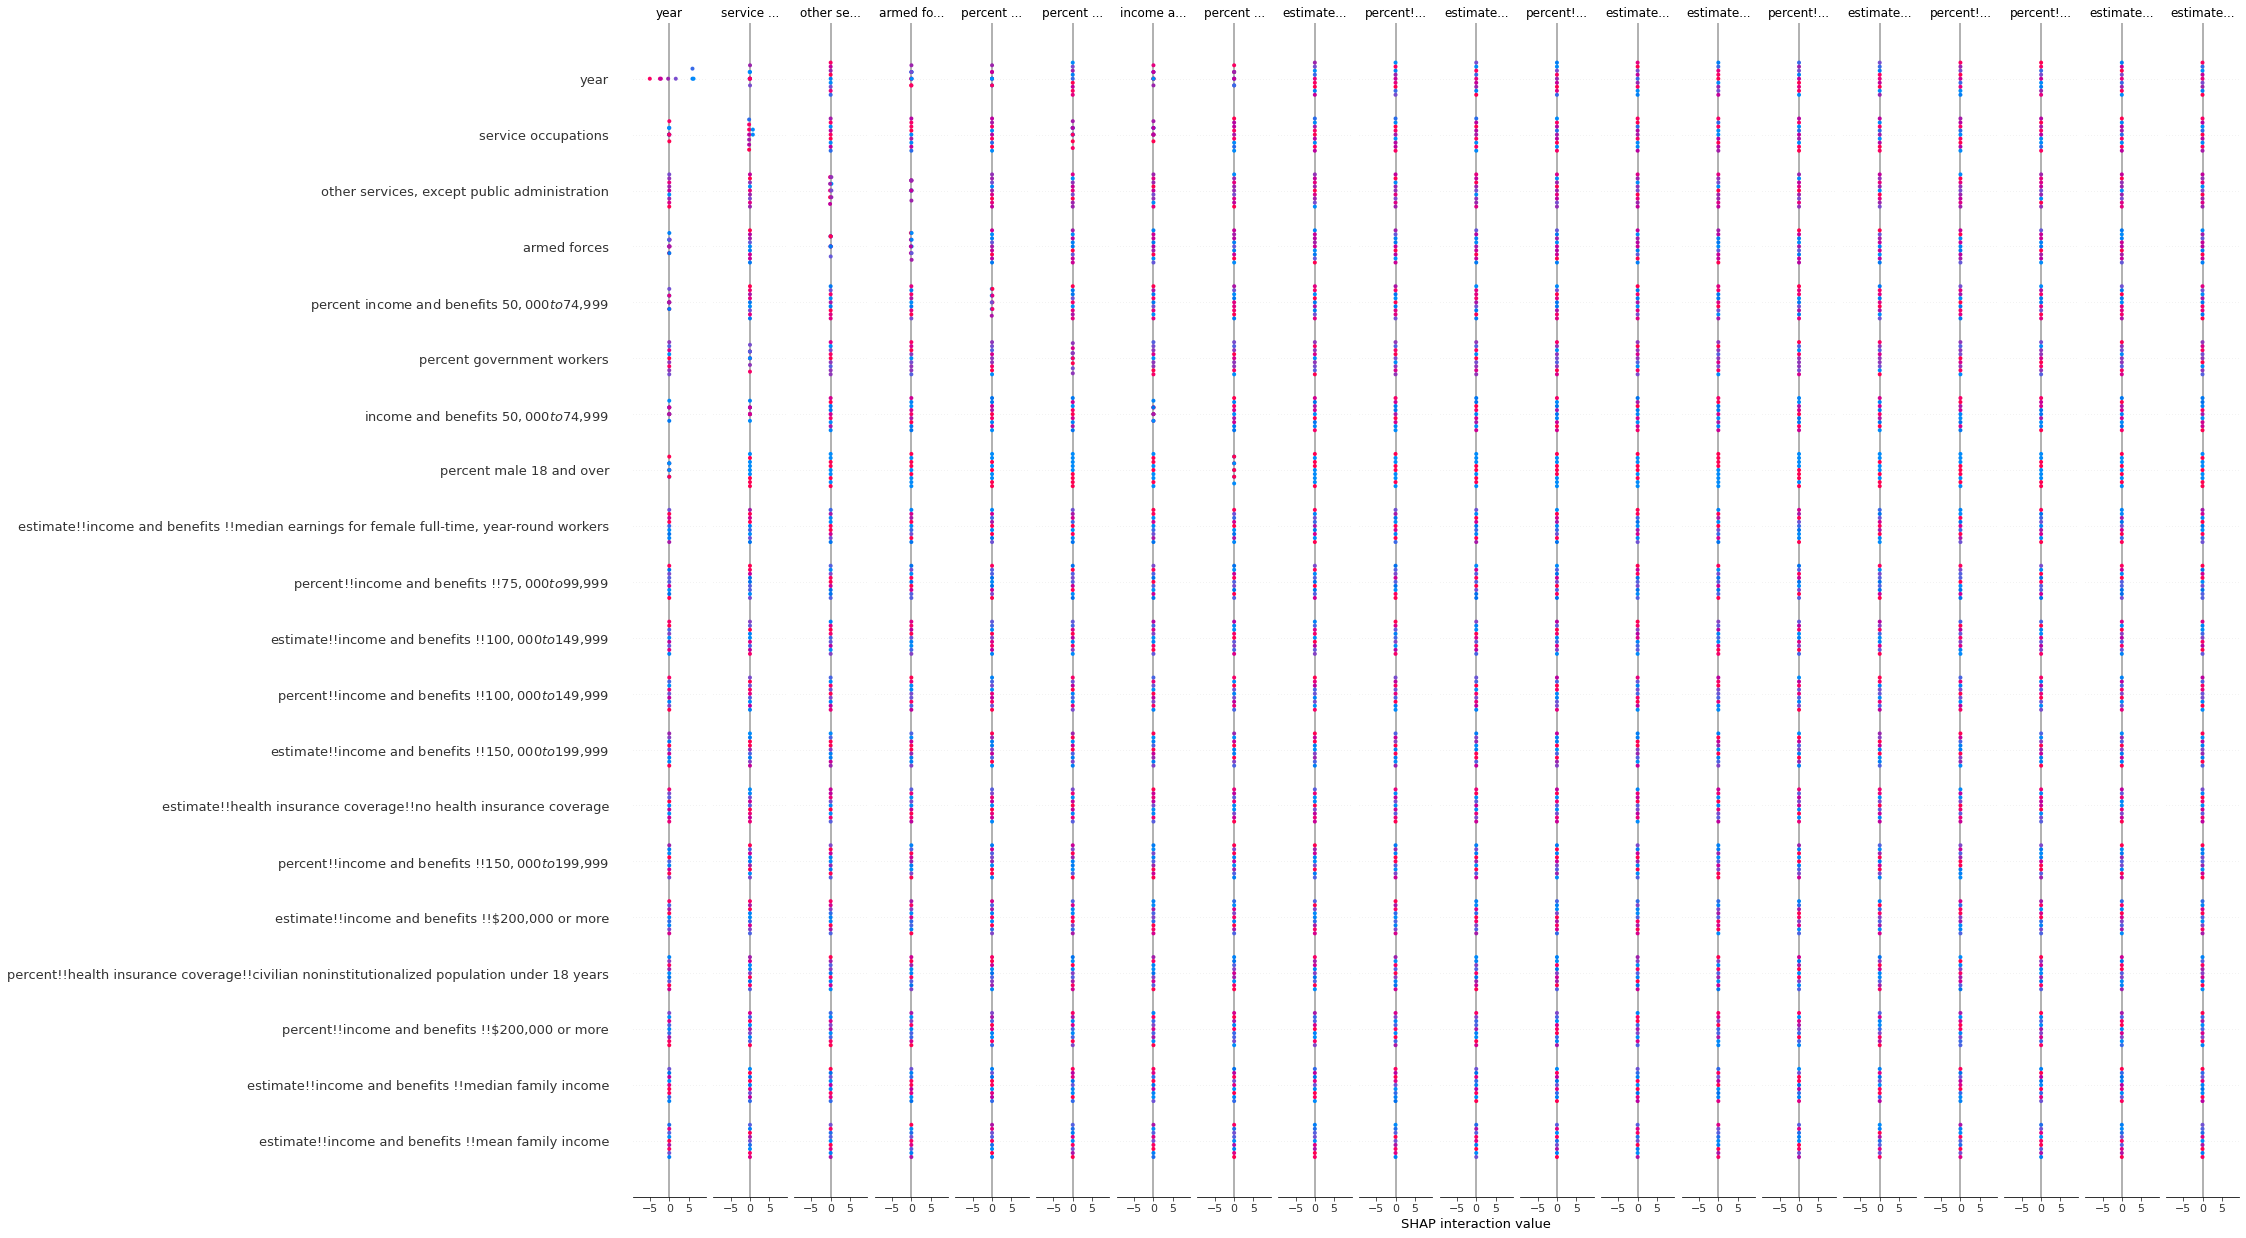

In [54]:
state = selected_states[2]
print(f'{list(all_states_dict.keys())[state]}')
shap.summary_plot(shap_dict[state]['shap_values'])
shap.summary_plot(shap_dict[state]['shap_interactions'], shap_dict[state]['df_X'], max_display=20)

Illinois


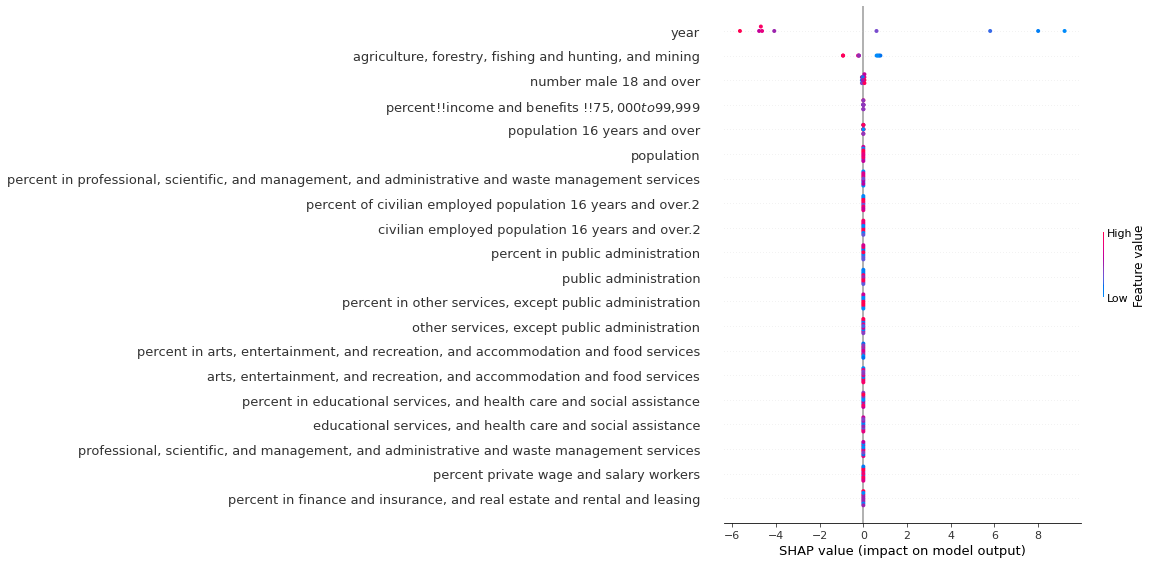

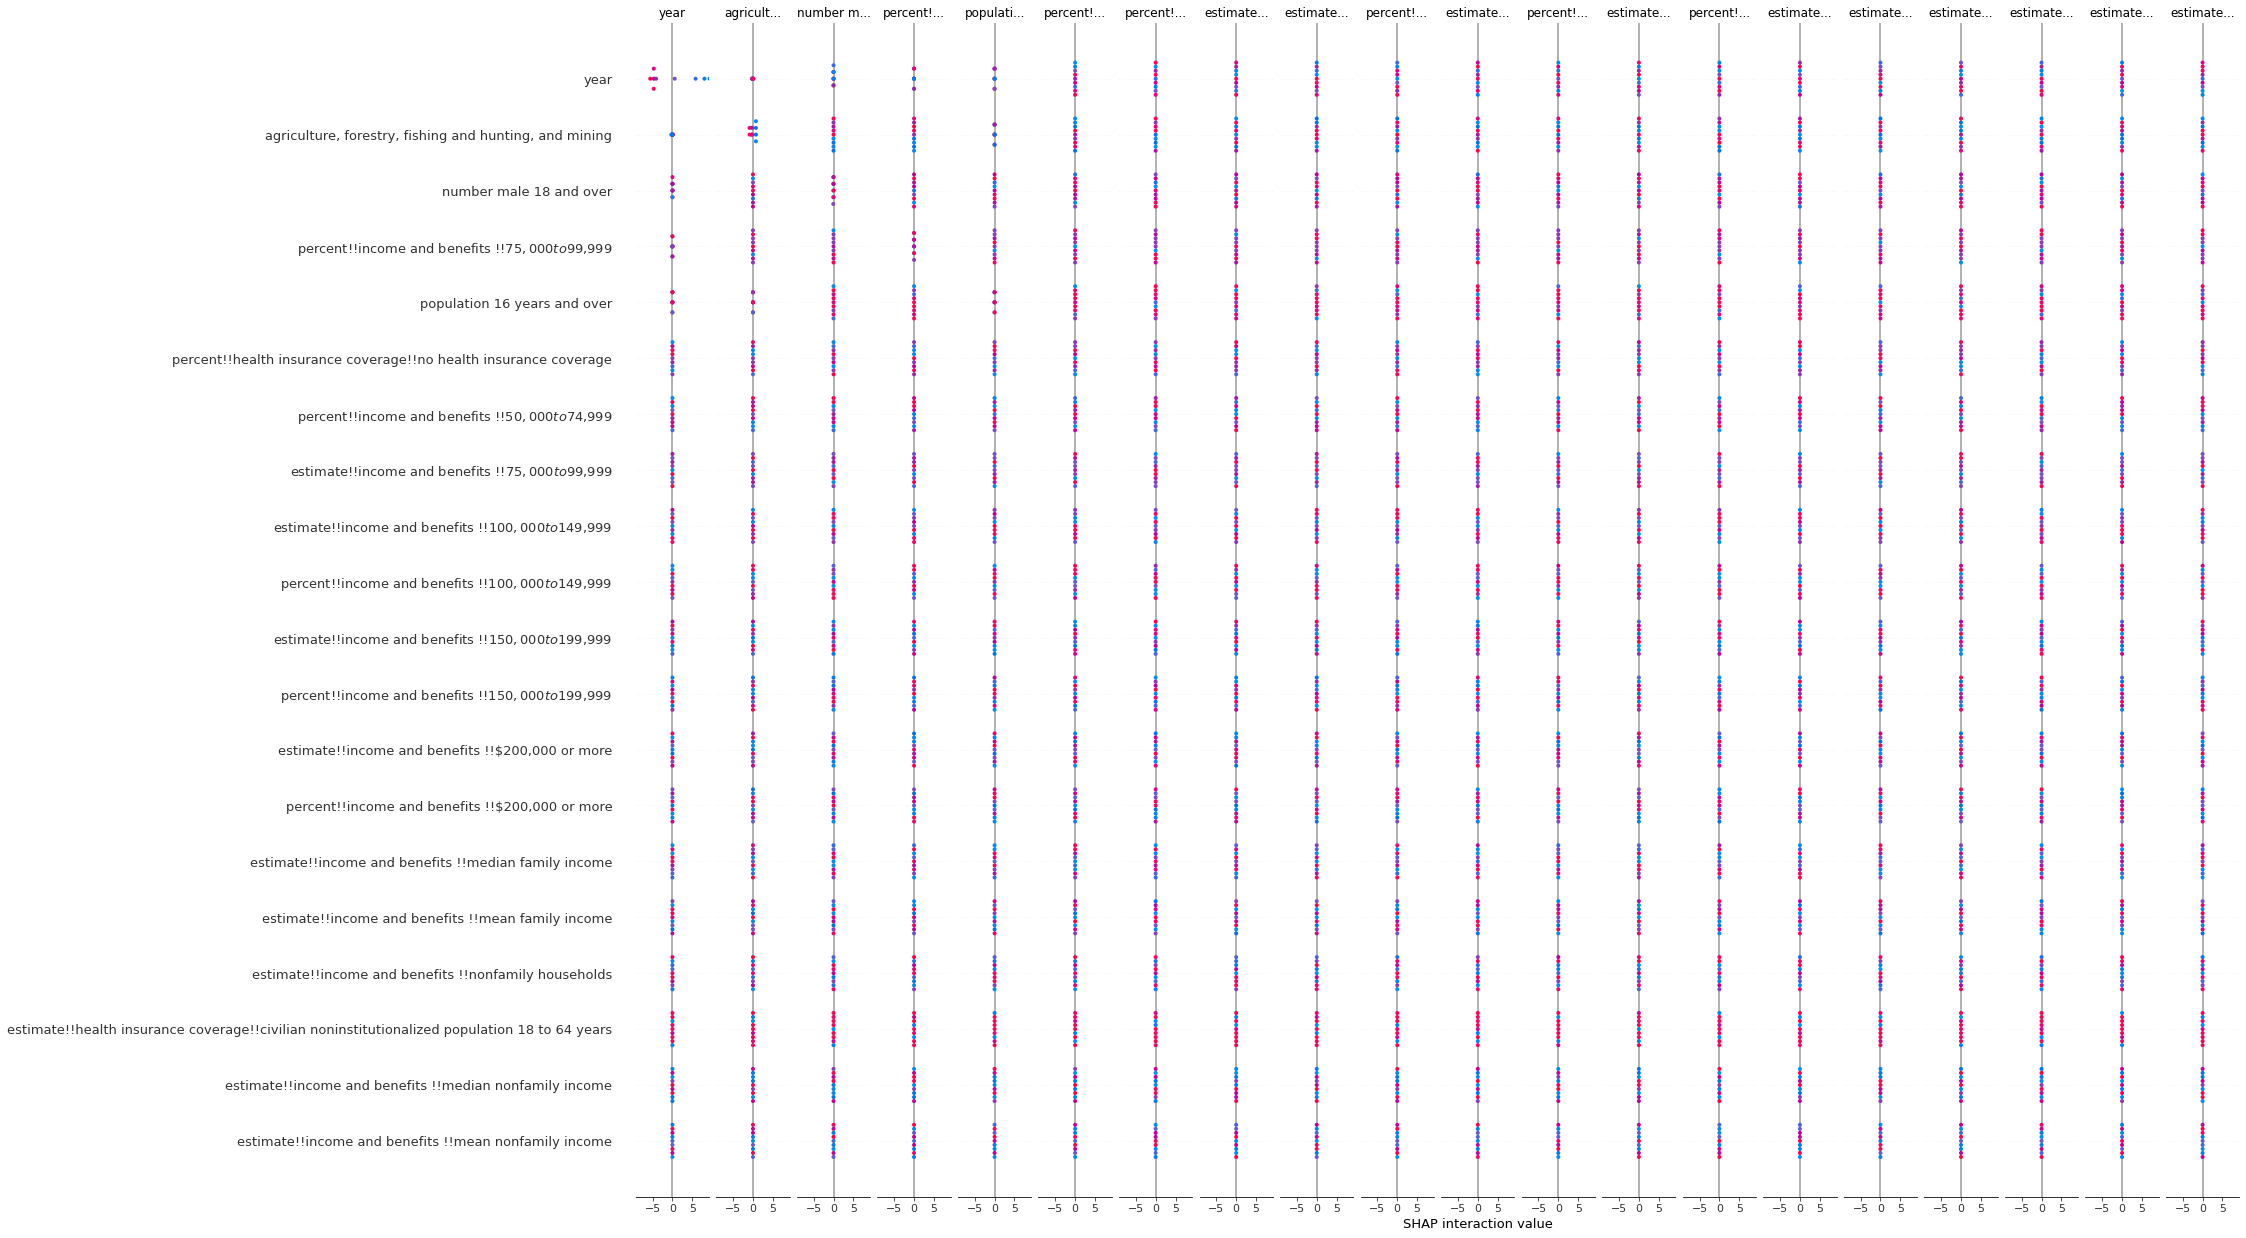

In [55]:
state = selected_states[3]
print(f'{list(all_states_dict.keys())[state]}')
shap.summary_plot(shap_dict[state]['shap_values'])
shap.summary_plot(shap_dict[state]['shap_interactions'], shap_dict[state]['df_X'], max_display=20)

New Mexico


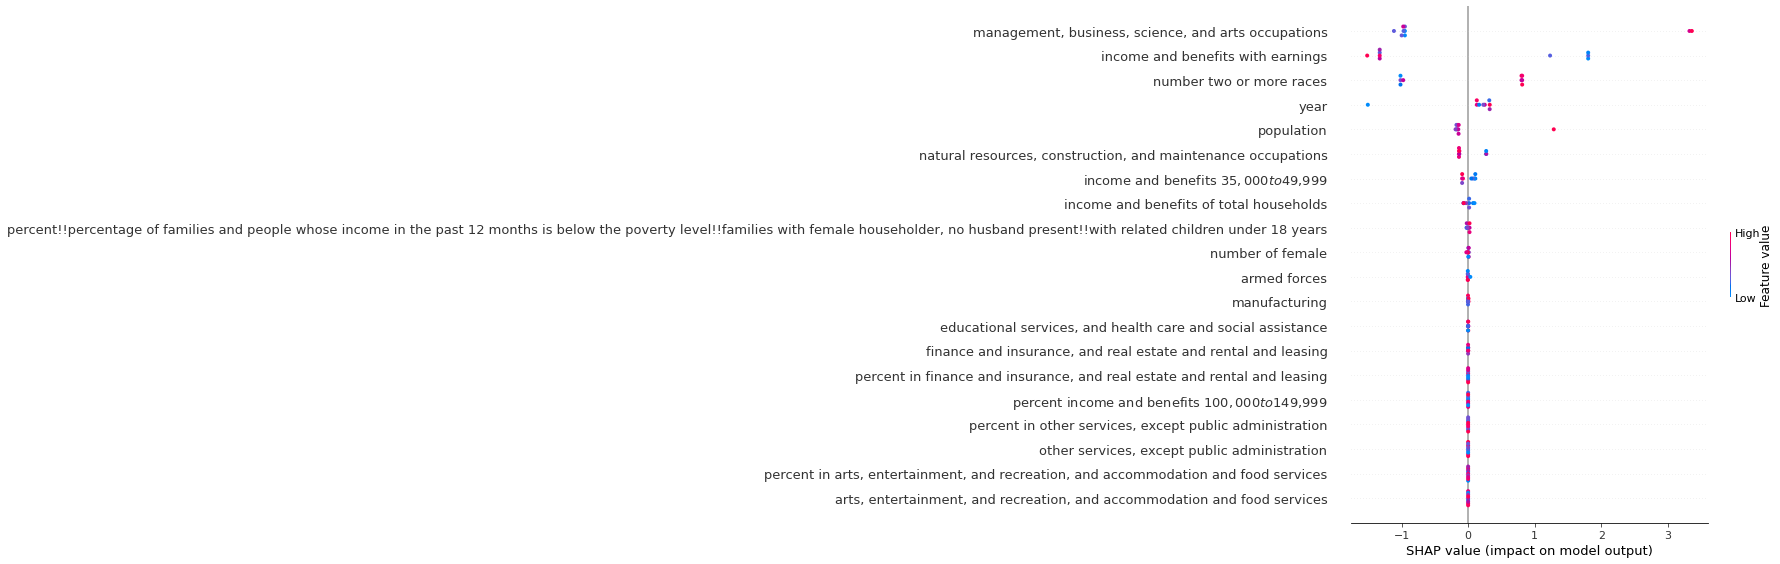

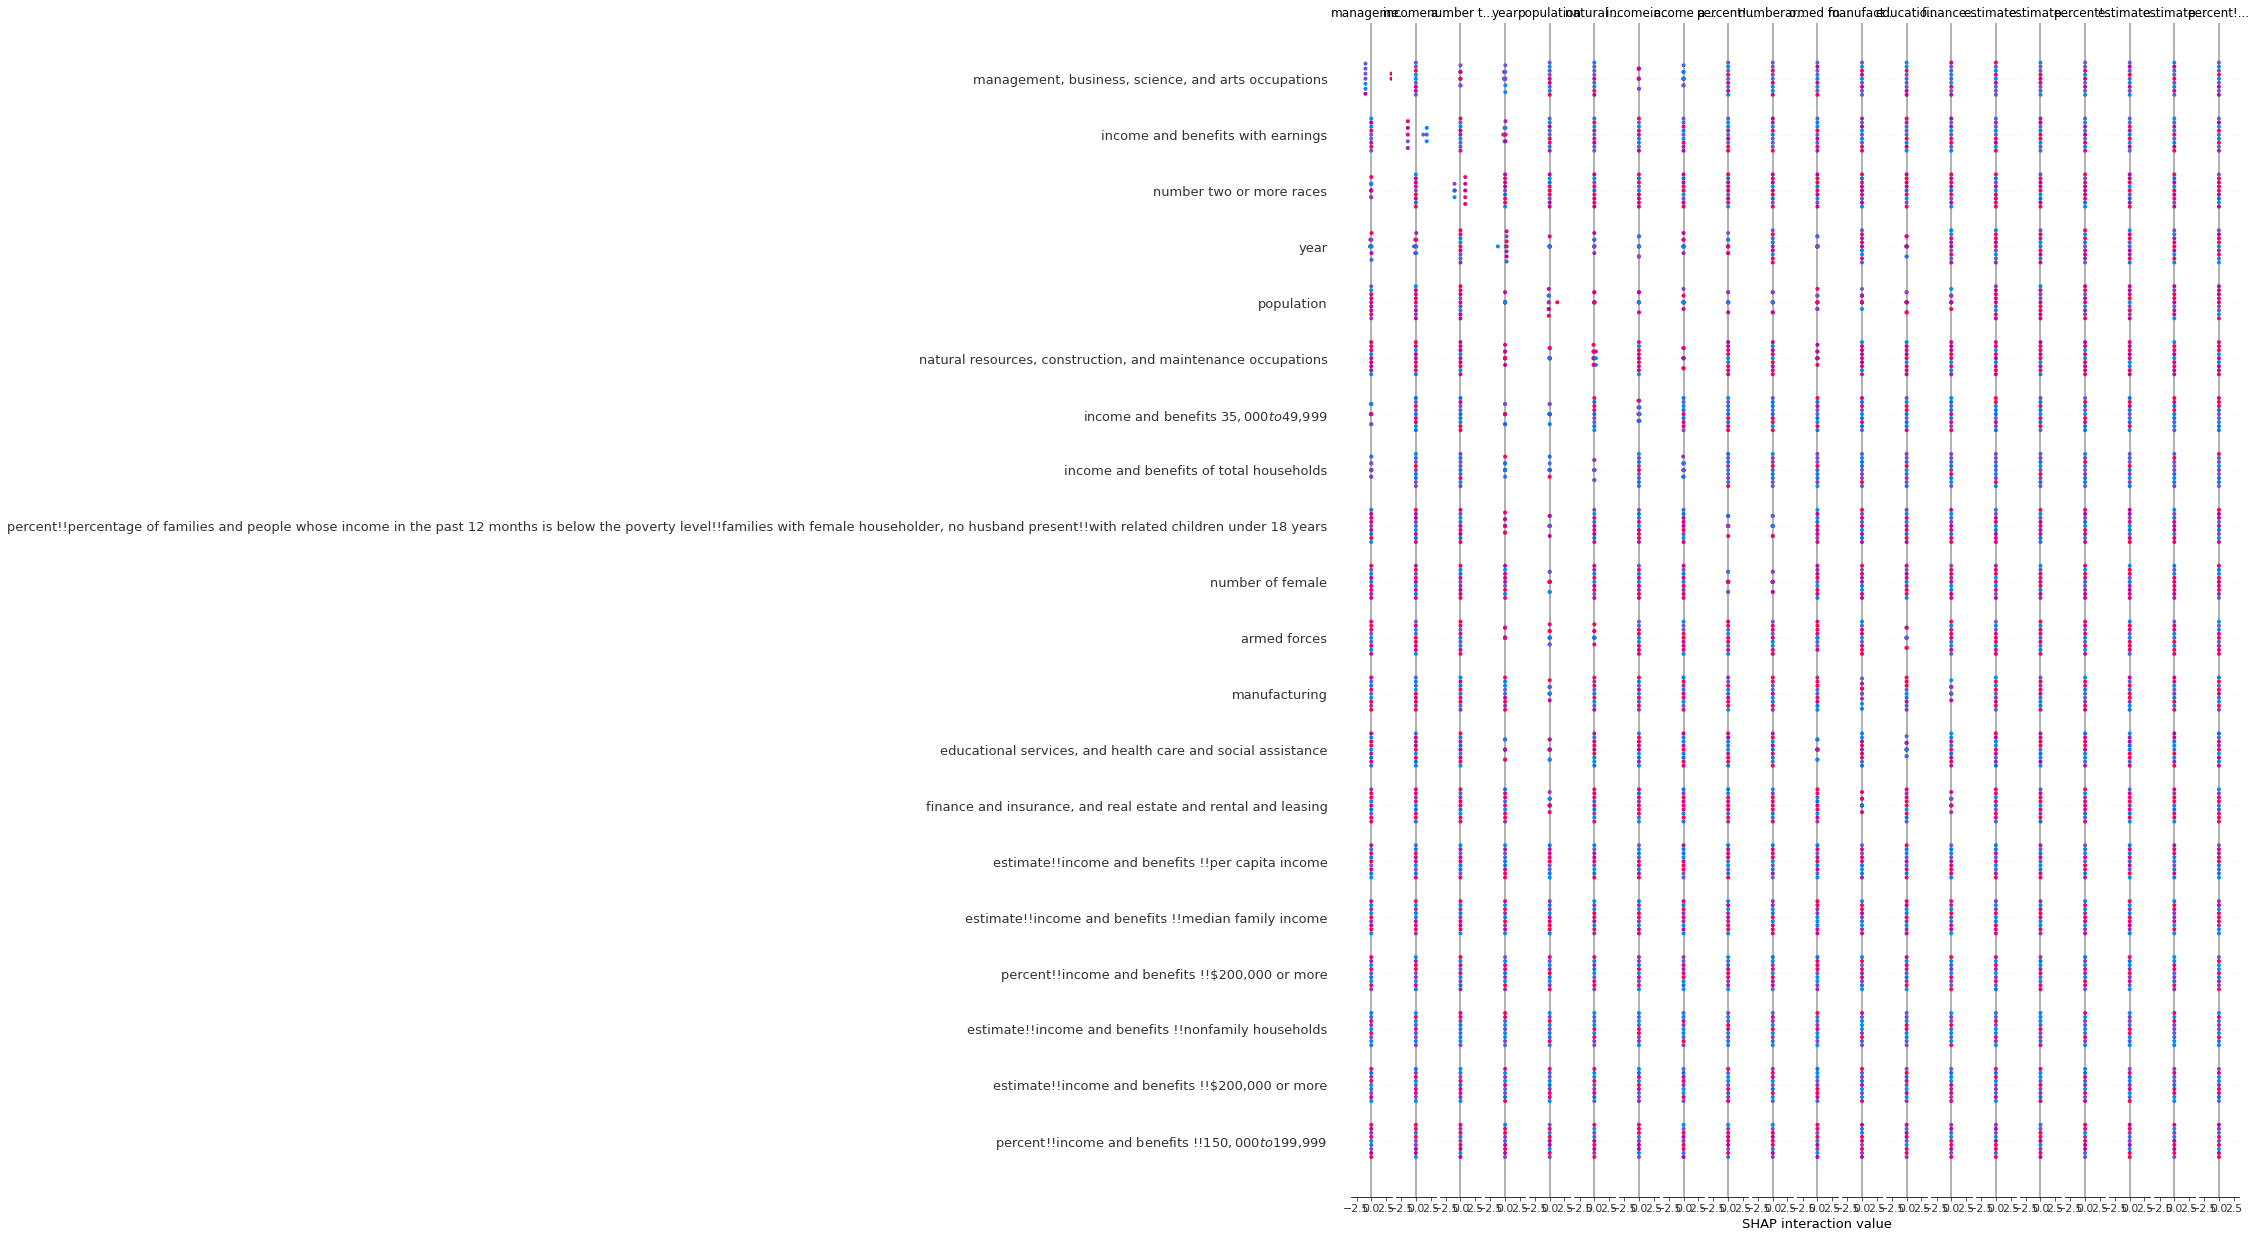

In [56]:
state = selected_states[4]
print(f'{list(all_states_dict.keys())[state]}')
shap.summary_plot(shap_dict[state]['shap_values'])
shap.summary_plot(shap_dict[state]['shap_interactions'], shap_dict[state]['df_X'], max_display=20)

If we build with model seperately, the year column has the significant influence to the prediction in some parts of model, this might be the other features are not significantly different.

# Task 3

Select two crimes caused by different reasons in demography, economy, and social characteristics, build a model (or models) to predict the crime rate of these two crime types separately

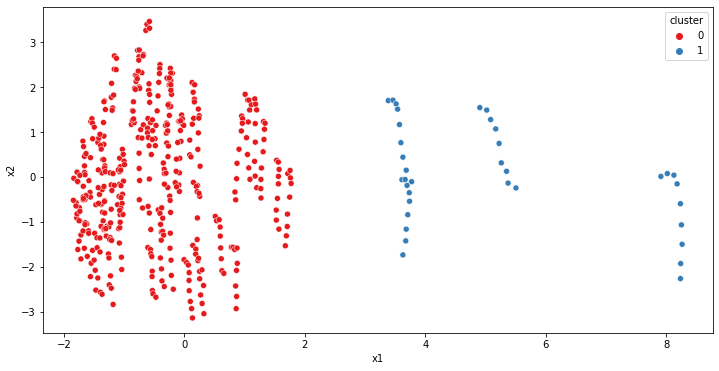

In [57]:
# use Kmeans to create 2 clusters to see the difference profiles
char_scaled = MinMaxScaler(range(-1, 1)).fit_transform(char_data)

dim_reducer = PCA(n_components=2)
char_reduced = dim_reducer.fit_transform(char_scaled)
# now we do not aggregate with year for each state to choose
char_reduced = pd.DataFrame(char_reduced, index=char_data.index, columns=['x1', 'x2'])

cluster_constructor = AgglomerativeClustering(n_clusters=2)
cluster_constructor.fit(char_reduced)

clusters = cluster_constructor.labels_

df_clusters = pd.DataFrame(np.concatenate([char_reduced, clusters[:, np.newaxis]], axis=1), 
    index=char_reduced.index, columns=['x1', 'x2', 'cluster']).reset_index().rename(columns={'state name': 'state'})
df_clusters['cluster'] = df_clusters['cluster'].astype(np.int32)
df_clusters['state name'] = df_clusters.reset_index()['state'].map(all_states_dict)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(x='x1', y='x2', palette='Set1', hue='cluster', data=df_clusters, ax=ax)
plt.show()

In [58]:
all_cs = {}
t = 0
for c in range(2):
    cs = df_clusters.loc[df_clusters['cluster'] == c, ['state name', 'year']].values.squeeze()
    print(f'Cluster: {c}(#={len(cs)})')
    all_cs[c] = cs
    t += len(cs)
print(f'Total = {t}')

Cluster: 0(#=414)
Cluster: 1(#=36)
Total = 450


In [59]:
np.random.seed(seed)
selected_cases = []
for c in range(2):
    idx = np.random.choice(np.arange(len(all_cs[c])))
    selected_cases.append(all_cs[c][idx])
print(f'Selected in each cluster: {selected_cases}')

Selected in each cluster: [array([  40, 2017], dtype=int64), array([   4, 2015], dtype=int64)]


In [60]:
case1, case2 = selected_cases
train_data_sep = data.loc[((data['state name'] == case1[0]) & (data['year'] == case1[1])) | \
    ((data['state name'] == case2[0]) & (data['year'] == case2[1])), :]
test_data_sep = data.loc[((data['state name'] == case1[0]) & (data['year'] == 2019)) | \
    ((data['state name'] == case2[0]) & (data['year'] == 2019)), :]

not make sense to train a model only using two data, but we can analysis using existing model, analyze with Task 1 model

In [66]:
model = xgb.Booster()
model.load_model(model_path / 'T1.xgb')

X_train, y_train = get_Xy(train_data_sep)
X_test, y_test = get_Xy(test_data_sep)

In [69]:
y_true = y_test['overall crime rate'].values
y_pred = model.predict(xgb.DMatrix(X_test, label=y_test))

model = task_dict['T1']['model']

print('Test Results:')
print(f'Mean Squared Error: {mean_squared_error(y_true=y_true, y_pred=y_pred):.4f}')
print(f'R2 Score: {r2_score(y_true=y_true, y_pred=y_pred)}')

Test Results:
Mean Squared Error: 10.4735
R2 Score: 0.7363245825212512


In [70]:
df_X, df_y = X_train, y_train
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_X)
shap_interactions = explainer.shap_interaction_values(df_X)

In [71]:
shap.force_plot(shap_values[0], df_X.iloc[0])

In [72]:
shap.force_plot(shap_values[1], df_X.iloc[1])